### Generate and test feature likelihood SOM using comsoDC2 sample

We will be using the `cosmoDC2_v1.1.4_small_photoz_magerr_10y_small` sample, accessible via GCR. A description of this catalog is provided here:

https://confluence.slac.stanford.edu/display/LSSTDESC/List+of+available+DC2+catalogs+created+by+PhotoZ

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('../python')

import os
import re
import time
import som
import pathlib

import pandas as pd
import seaborn as sns

from astropy.table import Table
from matplotlib.colors import LogNorm

In [3]:
from GCR import GCRQuery
import GCRCatalogs

In [4]:
seed = 44
rng = np.random.RandomState(seed)

sns.set()

In [6]:
home = pathlib.Path(os.getenv('HOME'))
data_path = home / 'lsst/repos/pz_bayes/data/feature_likelihood'

##### Figuring out how to select the correct columns

In [17]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image_photoz_magerr_10y')

In [22]:
columns = []
qtys = gc.list_all_quantities()
for qty in qtys:
    if 'err' in qty:
        columns.append(qty)
columns;

In [21]:
gc.list_all_quantities();

In [84]:
teststr = ['sed_7385_458_no_host_extinction',
 'mag_z_sdss',
 'otherLuminosities/diskLuminositiesStellar:B:rest:dustAtlas',
 'sed_5148_319_bulge_no_host_extinction',
 'size_bulge_true',
 'SEDs/totalLuminositiesStellar:SED_4048_251:rest',
 'SDSS_filters/diskLuminositiesStellar:SDSS_r:rest',
 'sed_2998_186_no_host_extinction',
 'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed:dustAtlas',
 'LSST_filters/diskLuminositiesStellar:LSST_g:observed',
 'baseDC2/sfr_percentile',
 'emissionLines/diskLineLuminosity:nitrogenII6584',
 'SDSS_filters/diskLuminositiesStellar:SDSS_u:rest',
 'scaterr_g',
 'mag_i_sdss',
 'baseDC2/target_halo_vz',
 'is_central',
 'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed:dustAtlas',
 'sed_4565_283',
 'mag_true_g_lsst_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_9978_1489:rest',
 'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed:dustAtlas',
 'baseDC2/obs_sfr_percentile',
 'baseDC2/redshift',
 'SEDs/spheroidLuminositiesStellar:SED_15143_2259:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_5467_339:rest:dustAtlas',
 'dec_true',
 'SEDs/spheroidLuminositiesStellar:SED_3590_222:rest',
 'sed_7385_458_disk_no_host_extinction',
 'LSST_filters/magnitude:LSST_i:observed:dustAtlas',
 'sed_8846_549',
 'SDSS_filters/magnitude:SDSS_z:rest',
 'SDSS_filters/magnitude:SDSS_g:observed:dustAtlas',
 'SDSS_filters/totalLuminositiesStellar:SDSS_z:observed:dustAtlas',
 'LSST_filters/spheroidLuminositiesStellar:LSST_i:rest:dustAtlas',
 'baseDC2/target_halo_mass',
 'sed_3184_197_disk',
 'SEDs/diskLuminositiesStellar:SED_9978_1489:rest:dustAtlas',
 'LSST_filters/totalLuminositiesStellar:LSST_u:observed',
 'baseDC2/restframe_extincted_sdss_abs_magr',
 'SEDs/spheroidLuminositiesStellar:SED_13177_1966:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_6166_382:rest:dustAtlas',
 'sed_5148_319',
 'matchUp/NumberSelected',
 'SEDs/spheroidLuminositiesStellar:SED_4848_300:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_7385_458:rest:dustAtlas',
 'sed_7385_458',
 'galaxy_id',
 'sed_5467_339_bulge_no_host_extinction',
 'emissionLines/diskLineLuminosity:oxygenII3726',
 'sed_6166_382_disk_no_host_extinction',
 'sed_13177_1966',
 'baseDC2/lightcone_rotation',
 'mag_y_lsst',
 'LSST_filters/spheroidLuminositiesStellar:LSST_g:observed:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_3381_209:rest:dustAtlas',
 'LSST_filters/totalLuminositiesStellar:LSST_y:rest',
 'SDSS_filters/totalLuminositiesStellar:SDSS_z:rest',
 'emissionLines/totalLineLuminosity:sulfurII6731',
 'otherLuminosities/diskLuminositiesStellar:Lyc:rest:dustAtlas',
 'mag_true_i_sdss_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_1246_306:rest:dustAtlas',
 'sed_6166_382_disk',
 'LSST_filters/magnitude:LSST_z:rest',
 'SEDs/diskLuminositiesStellar:SED_4848_300:rest:dustAtlas',
 'spinSpin',
 'mag_true_z',
 'mag_true_i_lsst_no_host_extinction',
 'halo_mass',
 'SEDs/spheroidLuminositiesStellar:SED_5148_319:rest',
 'sed_5467_339_disk_no_host_extinction',
 'SEDs/spheroidLuminositiesStellar:SED_8846_549:rest:dustAtlas',
 'mag_true_Y_lsst_no_host_extinction',
 'mag_z_lsst_no_host_extinction',
 'Mag_true_y_lsst_z0',
 'SEDs/spheroidLuminositiesStellar:SED_1933_474:rest:dustAtlas',
 'sed_15143_2259',
 'ellipticity_1_true',
 'SEDs/spheroidLuminositiesStellar:SED_5467_339:rest',
 'blackHoleMass',
 'morphology/spheroidMinorAxisArcsec',
 'SEDs/diskLuminositiesStellar:SED_5806_360:rest',
 'LSST_filters/diskLuminositiesStellar:LSST_y:observed:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_6166_382:rest:dustAtlas',
 'sed_6166_382',
 'emissionLines/diskLineLuminosity:sulfurII6716',
 'mag_true_z_lsst',
 'mag_z',
 'sed_4048_251_bulge_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_3381_209:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_3590_222:rest',
 'Mag_true_g_lsst_z0_no_host_extinction',
 'LSST_filters/spheroidLuminositiesStellar:LSST_z:rest:dustAtlas',
 'SEDs/spheroidLuminositiesStellar:SED_5806_360:rest:dustAtlas',
 'SDSS_filters/diskLuminositiesStellar:SDSS_u:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_1933_474:rest',
 'sed_6166_382_bulge_no_host_extinction',
 'LSST_filters/spheroidLuminositiesStellar:LSST_z:observed',
 'SEDs/spheroidLuminositiesStellar:SED_6548_406:rest',
 'SEDs/totalLuminositiesStellar:SED_4299_266:rest:dustAtlas',
 'ellipticity_disk_true',
 'scatmag_y',
 'morphology/totalEllipticity',
 'LSST_filters/spheroidLuminositiesStellar:LSST_g:rest',
 'shear1',
 'SEDs/totalLuminositiesStellar:SED_4048_251:rest:dustAtlas',
 'otherLuminosities/diskLuminositiesStellar:OxygenContinuum:rest',
 'spheroidVelocity',
 'mag_true_Y_lsst',
 'SEDs/diskLuminositiesStellar:SED_3184_197:rest',
 'Mag_true_g_sdss_z0_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_8329_517:rest:dustAtlas',
 'baseDC2/restframe_extincted_sdss_abs_magg',
 'LSST_filters/diskLuminositiesStellar:LSST_r:observed:dustAtlas',
 'Mag_true_g_lsst_z0',
 'diskAbundancesStellarMetals',
 'otherLuminosities/spheroidLuminositiesStellar:B:rest:dustAtlas',
 'mag_true_g_lsst',
 'LSST_filters/magnitude:LSST_r:observed',
 'SEDs/spheroidLuminositiesStellar:SED_11467_1710:rest:dustAtlas',
 'sed_4299_266_disk',
 'SEDs/spheroidLuminositiesStellar:SED_15143_2259:rest',
 'baseDC2/dec',
 'emissionLines/spheroidLineLuminosity:oxygenIII4959',
 'emissionLines/totalLineLuminosity:oxygenII3726',
 'sed_1000_246_disk_no_host_extinction',
 'matchUp/dustFactor',
 'baseDC2/host_centric_vx',
 'galaxyID',
 'mag_u_sdss_no_host_extinction',
 'sed_2407_591',
 'vz',
 'position_x',
 'SEDs/spheroidLuminositiesStellar:SED_8329_517:rest',
 'emissionLines/totalLineLuminosity:balmerBeta4861',
 'sed_4048_251_disk',
 'sed_7385_458_bulge',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_r:rest',
 'sed_4048_251_bulge',
 'sed_4848_300',
 'SDSS_filters/totalLuminositiesStellar:SDSS_z:observed',
 'emissionLines/spheroidLineLuminosity:oxygenII3726',
 'sed_11467_1710_disk_no_host_extinction',
 'morphology/diskEllipticity1',
 'SEDs/diskLuminositiesStellar:SED_3381_209:rest',
 'morphology/totalEllipticity2',
 'baseDC2/target_halo_redshift',
 'SEDs/totalLuminositiesStellar:SED_1246_306:rest',
 'SEDs/diskLuminositiesStellar:SED_5148_319:rest',
 'LSST_filters/diskLuminositiesStellar:LSST_y:rest',
 'baseDC2/vy',
 'sed_2998_186',
 'SEDs/spheroidLuminositiesStellar:SED_3184_197:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_3812_236:rest',
 'SEDs/diskLuminositiesStellar:SED_17402_2596:rest',
 'diskStarFormationRate',
 'LSST_filters/magnitude:LSST_y:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_1552_381:rest',
 'SDSS_filters/diskLuminositiesStellar:SDSS_g:rest:dustAtlas',
 'SEDs/spheroidLuminositiesStellar:SED_1933_474:rest',
 'SEDs/diskLuminositiesStellar:SED_1000_246:rest',
 'otherLuminosities/spheroidLuminositiesStellar:V:rest',
 'SEDs/totalLuminositiesStellar:SED_1552_381:rest',
 'mag_true_g_sdss_no_host_extinction',
 'otherLuminosities/spheroidLuminositiesStellar:B:rest',
 'SEDs/spheroidLuminositiesStellar:SED_9978_1489:rest:dustAtlas',
 'Mag_true_r_lsst_z0',
 'mag_r_lsst',
 'sed_6954_431_disk_no_host_extinction',
 'sed_1933_474',
 'LSST_filters/spheroidLuminositiesStellar:LSST_r:observed',
 'SDSS_filters/totalLuminositiesStellar:SDSS_z:rest:dustAtlas',
 'scaterr_i',
 'sed_11467_1710_no_host_extinction',
 'SEDs/totalLuminositiesStellar:SED_3381_209:rest',
 'sed_9978_1489_disk',
 'LSST_filters/totalLuminositiesStellar:LSST_g:rest',
 'baseDC2/galaxy_id',
 'sed_13177_1966_no_host_extinction',
 'mag_u_lsst',
 'SEDs/totalLuminositiesStellar:SED_5806_360:rest',
 'SEDs/diskLuminositiesStellar:SED_6954_431:rest',
 'sed_7843_486_disk_no_host_extinction',
 'emissionLines/diskLineLuminosity:balmerBeta4861',
 'SEDs/spheroidLuminositiesStellar:SED_4848_300:rest',
 'hostHaloTag',
 'LSST_filters/diskLuminositiesStellar:LSST_u:rest',
 'otherLuminosities/totalLuminositiesStellar:HeliumContinuum:rest:dustAtlas',
 'LSST_filters/magnitude:LSST_z:rest:dustAtlas',
 'morphology/spheroidEllipticity1',
 'sed_11467_1710_bulge',
 'scatmag_i',
 'SEDs/totalLuminositiesStellar:SED_6548_406:rest:dustAtlas',
 'sed_6548_406_bulge_no_host_extinction',
 'sed_9395_583_disk_no_host_extinction',
 'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed:dustAtlas',
 'infallIndex',
 'SDSS_filters/totalLuminositiesStellar:SDSS_g:observed',
 'LSST_filters/diskLuminositiesStellar:LSST_y:rest:dustAtlas',
 'SEDs/spheroidLuminositiesStellar:SED_13177_1966:rest',
 'morphology/spheroidSersicIndex',
 'SDSS_filters/magnitude:SDSS_g:rest',
 'sed_11467_1710',
 'SEDs/spheroidLuminositiesStellar:SED_1552_381:rest',
 'SEDs/diskLuminositiesStellar:SED_15143_2259:rest:dustAtlas',
 'sed_6166_382_bulge',
 'LSST_filters/magnitude:LSST_u:rest:dustAtlas',
 'baseDC2/halo_id',
 'otherLuminosities/totalLuminositiesStellar:HeliumContinuum:rest',
 'sed_2998_186_disk',
 'LSST_filters/totalLuminositiesStellar:LSST_i:rest:dustAtlas',
 'scaterr_z',
 'SEDs/spheroidLuminositiesStellar:SED_4048_251:rest',
 'LSST_filters/spheroidLuminositiesStellar:LSST_u:rest:dustAtlas',
 'LSST_filters/totalLuminositiesStellar:LSST_r:observed:dustAtlas',
 'emissionLines/diskLineLuminosity:oxygenIII5007',
 'totalMassStellar',
 'SEDs/totalLuminositiesStellar:SED_15143_2259:rest',
 'SDSS_filters/magnitude:SDSS_z:rest:dustAtlas',
 'sed_4848_300_bulge_no_host_extinction',
 'SEDs/totalLuminositiesStellar:SED_9395_583:rest',
 'blackHoleEddingtonRatio',
 'vy',
 'mag_Y_lsst',
 'LSST_filters/totalLuminositiesStellar:LSST_u:observed:dustAtlas',
 'sed_6548_406_bulge',
 'x',
 'sed_3590_222_disk_no_host_extinction',
 'emissionLines/diskLineLuminosity:oxygenIII4959',
 'SEDs/totalLuminositiesStellar:SED_9395_583:rest:dustAtlas',
 'sed_9395_583_bulge_no_host_extinction',
 'sed_4565_283_disk',
 'LSST_filters/diskLuminositiesStellar:LSST_z:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_2407_591:rest',
 'Mag_true_y_lsst_z0_no_host_extinction',
 'baseDC2/host_halo_y',
 'shear_2',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:rest',
 'z',
 'morphology/diskHalfLightRadiusArcsec',
 'convergence',
 'sed_3590_222_no_host_extinction',
 'sed_9395_583_no_host_extinction',
 'SDSS_filters/diskLuminositiesStellar:SDSS_g:rest',
 'LSST_filters/diskLuminositiesStellar:LSST_z:observed',
 'sed_2998_186_bulge',
 'LSST_filters/magnitude:LSST_y:observed:dustAtlas',
 'Mag_true_z_sdss_z0_no_host_extinction',
 'SEDs/totalLuminositiesStellar:SED_8846_549:rest:dustAtlas',
 'sed_3381_209_bulge',
 'LSST_filters/spheroidLuminositiesStellar:LSST_z:observed:dustAtlas',
 'R_v_disk',
 'SEDs/totalLuminositiesStellar:SED_7843_486:rest',
 'LSST_filters/magnitude:LSST_i:rest',
 'sed_5148_319_disk',
 'sed_5467_339_bulge',
 'mag_true_r',
 'SEDs/diskLuminositiesStellar:SED_2998_186:rest:dustAtlas',
 'LSST_filters/spheroidLuminositiesStellar:LSST_r:rest',
 'SEDs/diskLuminositiesStellar:SED_5467_339:rest:dustAtlas',
 'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed',
 'baseDC2/sfr',
 'mag_u_sdss',
 'SEDs/diskLuminositiesStellar:SED_6548_406:rest:dustAtlas',
 'sed_13177_1966_bulge',
 'sersic_bulge',
 'mag_true_y_lsst_no_host_extinction',
 'Mag_true_i_lsst_z0_no_host_extinction',
 'emissionLines/spheroidLineLuminosity:balmerAlpha6563',
 'SDSS_filters/magnitude:SDSS_z:observed',
 'SEDs/totalLuminositiesStellar:SED_5467_339:rest',
 'emissionLines/totalLineLuminosity:sulfurII6716',
 'SDSS_filters/totalLuminositiesStellar:SDSS_u:rest:dustAtlas',
 'shear_1',
 'SEDs/totalLuminositiesStellar:SED_13177_1966:rest',
 'sed_4048_251',
 'position_y',
 'baseDC2/host_halo_x',
 'otherLuminosities/diskLuminositiesStellar:HeliumContinuum:rest:dustAtlas',
 'sed_3184_197_disk_no_host_extinction',
 'SEDs/spheroidLuminositiesStellar:SED_2407_591:rest:dustAtlas',
 'SDSS_filters/totalLuminositiesStellar:SDSS_i:observed:dustAtlas',
 'sed_6954_431_no_host_extinction',
 'LSST_filters/spheroidLuminositiesStellar:LSST_g:observed',
 'LSST_filters/totalLuminositiesStellar:LSST_u:rest',
 'LSST_filters/spheroidLuminositiesStellar:LSST_i:rest',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_i:observed:dustAtlas',
 'SDSS_filters/totalLuminositiesStellar:SDSS_r:observed:dustAtlas',
 'sed_6954_431_bulge_no_host_extinction',
 'LSST_filters/diskLuminositiesStellar:LSST_g:rest',
 'sed_1246_306_disk_no_host_extinction',
 'SEDs/spheroidLuminositiesStellar:SED_7385_458:rest',
 'Mag_true_r_lsst_z0_no_host_extinction',
 'mag_i_sdss_no_host_extinction',
 'LSST_filters/spheroidLuminositiesStellar:LSST_y:observed',
 'morphology/diskMinorAxisArcsec',
 'mag_true_u_sdss_no_host_extinction',
 'mag_true_u_lsst',
 'SEDs/diskLuminositiesStellar:SED_8846_549:rest:dustAtlas',
 'otherLuminosities/totalLuminositiesStellar:B:rest',
 'SEDs/spheroidLuminositiesStellar:SED_4565_283:rest',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_u:observed:dustAtlas',
 'sed_5467_339_disk',
 'mag_z_lsst',
 'SEDs/totalLuminositiesStellar:SED_2998_186:rest',
 'SEDs/spheroidLuminositiesStellar:SED_4565_283:rest:dustAtlas',
 'morphology/totalAxisRatio',
 'SEDs/spheroidLuminositiesStellar:SED_2998_186:rest',
 'LSST_filters/totalLuminositiesStellar:LSST_i:observed:dustAtlas',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_u:rest',
 'spheroidMassStellar',
 'y',
 'morphology/spheroidHalfLightRadiusArcsec',
 'baseDC2/target_halo_x',
 'SEDs/totalLuminositiesStellar:SED_11467_1710:rest',
 'otherLuminosities/totalLuminositiesStellar:V:rest',
 'mag_r_lsst_no_host_extinction',
 'mag_y',
 'SEDs/totalLuminositiesStellar:SED_3184_197:rest',
 'LSST_filters/magnitude:LSST_g:rest',
 'mag_g',
 'matchUp/GalacticusNodeIndex',
 'sed_2998_186_disk_no_host_extinction',
 'LSST_filters/spheroidLuminositiesStellar:LSST_i:observed:dustAtlas',
 'baseDC2/hostid',
 'otherLuminosities/totalLuminositiesStellar:V:rest:dustAtlas',
 'sed_2407_591_bulge_no_host_extinction',
 'SEDs/totalLuminositiesStellar:SED_1552_381:rest:dustAtlas',
 'stellar_mass',
 'SDSS_filters/magnitude:SDSS_r:observed',
 'SEDs/totalLuminositiesStellar:SED_3590_222:rest',
 'sed_3812_236_bulge',
 'SDSS_filters/magnitude:SDSS_r:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_9395_583:rest',
 'sed_1246_306_disk',
 'SEDs/totalLuminositiesStellar:SED_2407_591:rest:dustAtlas',
 'sed_4048_251_disk_no_host_extinction',
 'baseDC2/vz',
 'baseDC2/sm',
 'SEDs/diskLuminositiesStellar:SED_17402_2596:rest:dustAtlas',
 'SDSS_filters/magnitude:SDSS_u:rest',
 'SDSS_filters/totalLuminositiesStellar:SDSS_u:rest',
 'sed_3381_209_disk',
 'sed_3184_197_bulge_no_host_extinction',
 'position_z',
 'redshiftHubble',
 'emissionLines/totalLineLuminosity:oxygenIII5007',
 'sed_7843_486_bulge_no_host_extinction',
 'SDSS_filters/totalLuminositiesStellar:SDSS_u:observed',
 'sed_3812_236',
 'LSST_filters/diskLuminositiesStellar:LSST_z:observed:dustAtlas',
 'scatmag_g',
 'SDSS_filters/totalLuminositiesStellar:SDSS_i:rest',
 'otherLuminosities/diskLuminositiesStellar:Lyc:rest',
 'mag_r_sdss',
 'position_angle_true',
 'mag_g_lsst_no_host_extinction',
 'Mag_true_i_sdss_z0',
 'sed_8329_517_disk_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_9395_583:rest:dustAtlas',
 'emissionLines/totalLineLuminosity:balmerAlpha6563',
 'LSST_filters/spheroidLuminositiesStellar:LSST_g:rest:dustAtlas',
 'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed',
 'LSST_filters/totalLuminositiesStellar:LSST_z:observed',
 'baseDC2/target_halo_vx',
 'mag_true_z_sdss_no_host_extinction',
 'morphology/spheroidHalfLightRadius',
 'baseDC2/restframe_extincted_sdss_gr',
 'SDSS_filters/diskLuminositiesStellar:SDSS_i:rest:dustAtlas',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:rest:dustAtlas',
 'otherLuminosities/spheroidLuminositiesStellar:V:rest:dustAtlas',
 'SEDs/spheroidLuminositiesStellar:SED_6166_382:rest:dustAtlas',
 'sed_1552_381_bulge_no_host_extinction',
 'sed_3590_222',
 'ellipticity_1_disk_true',
 'sed_5806_360_no_host_extinction',
 'baseDC2/host_centric_vz',
 'sed_1552_381_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_6166_382:rest',
 'SEDs/spheroidLuminositiesStellar:SED_6548_406:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_8329_517:rest',
 'morphology/diskAxisRatio',
 'morphology/diskHalfLightRadius',
 'baseDC2/host_centric_z',
 'LSST_filters/diskLuminositiesStellar:LSST_r:observed',
 'baseDC2/ra',
 'sed_3381_209_no_host_extinction',
 'SEDs/totalLuminositiesStellar:SED_9978_1489:rest:dustAtlas',
 'LSST_filters/diskLuminositiesStellar:LSST_i:rest',
 'SEDs/diskLuminositiesStellar:SED_5806_360:rest:dustAtlas',
 'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed:dustAtlas',
 'morphology/totalEllipticity1',
 'LSST_filters/magnitude:LSST_g:rest:dustAtlas',
 'LSST_filters/totalLuminositiesStellar:LSST_u:rest:dustAtlas',
 'ra_true',
 'baseDC2/host_centric_y',
 'sed_7843_486',
 'sed_7385_458_disk',
 'LSST_filters/totalLuminositiesStellar:LSST_g:observed',
 'velocity_z',
 'LSST_filters/magnitude:LSST_i:rest:dustAtlas',
 'SEDs/spheroidLuminositiesStellar:SED_3381_209:rest:dustAtlas',
 'sed_15143_2259_bulge',
 'sed_6166_382_no_host_extinction',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:rest',
 'sed_4848_300_disk_no_host_extinction',
 'SEDs/spheroidLuminositiesStellar:SED_6954_431:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_3812_236:rest',
 'SEDs/totalLuminositiesStellar:SED_3812_236:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_7843_486:rest',
 'ellipticity_1_bulge_true',
 'otherLuminosities/spheroidLuminositiesStellar:HeliumContinuum:rest',
 'SEDs/spheroidLuminositiesStellar:SED_7843_486:rest',
 'sed_8846_549_no_host_extinction',
 'LSST_filters/magnitude:LSST_u:observed:dustAtlas',
 'mag_true_u_sdss',
 'LSST_filters/magnitude:LSST_g:observed:dustAtlas',
 'LSST_filters/totalLuminositiesStellar:LSST_g:observed:dustAtlas',
 'SEDs/spheroidLuminositiesStellar:SED_17402_2596:rest:dustAtlas',
 'sed_1000_246_disk',
 'SEDs/spheroidLuminositiesStellar:SED_7385_458:rest:dustAtlas',
 'emissionLines/diskLineLuminosity:sulfurII6731',
 'morphology/spheroidEllipticity',
 'otherLuminosities/spheroidLuminositiesStellar:Lyc:rest',
 'SEDs/diskLuminositiesStellar:SED_4048_251:rest:dustAtlas',
 'baseDC2/mvir',
 'totalVelocity',
 'sed_1000_246',
 'LSST_filters/magnitude:LSST_i:observed',
 'LSST_filters/totalLuminositiesStellar:LSST_r:rest',
 'SDSS_filters/diskLuminositiesStellar:SDSS_z:rest',
 'baseDC2/is_on_red_sequence_ri',
 'sed_8846_549_bulge',
 'sed_17402_2596_disk',
 'SEDs/spheroidLuminositiesStellar:SED_3381_209:rest',
 'SDSS_filters/totalLuminositiesStellar:SDSS_u:observed:dustAtlas',
 'sed_17402_2596_bulge',
 'mag_true_y',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_7385_458:rest:dustAtlas',
 'LSST_filters/magnitude:LSST_u:rest',
 'SEDs/totalLuminositiesStellar:SED_6548_406:rest',
 'SEDs/spheroidLuminositiesStellar:SED_9395_583:rest',
 'baseDC2/z',
 'LSST_filters/spheroidLuminositiesStellar:LSST_u:rest',
 'otherLuminosities/totalLuminositiesStellar:Lyc:rest',
 'sed_15143_2259_no_host_extinction',
 'SDSS_filters/diskLuminositiesStellar:SDSS_z:rest:dustAtlas',
 'LSST_filters/magnitude:LSST_r:rest:dustAtlas',
 'SEDs/spheroidLuminositiesStellar:SED_8329_517:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_15143_2259:rest:dustAtlas',
 'morphology/spheroidEllipticity2',
 'LSST_filters/diskLuminositiesStellar:LSST_r:rest:dustAtlas',
 'LSST_filters/magnitude:LSST_u:observed',
 'baseDC2/host_centric_x',
 'mag_true_i_lsst',
 'morphology/diskMajorAxisArcsec',
 'LSST_filters/magnitude:LSST_y:rest',
 'emissionLines/totalLineLuminosity:oxygenIII4959',
 'sed_5148_319_bulge',
 'size_true',
 'LSST_filters/diskLuminositiesStellar:LSST_u:observed',
 'SEDs/diskLuminositiesStellar:SED_11467_1710:rest',
 'sed_9978_1489_bulge_no_host_extinction',
 'mag_g_sdss',
 'sed_6548_406',
 'scatmag_u',
 'sed_3590_222_bulge',
 'sed_3381_209',
 'sed_11467_1710_disk',
 'Mag_true_i_lsst_z0',
 'SEDs/totalLuminositiesStellar:SED_17402_2596:rest:dustAtlas',
 'SDSS_filters/magnitude:SDSS_r:observed:dustAtlas',
 'SDSS_filters/diskLuminositiesStellar:SDSS_i:rest',
 'SDSS_filters/diskLuminositiesStellar:SDSS_g:observed:dustAtlas',
 'emissionLines/spheroidLineLuminosity:nitrogenII6584',
 'LSST_filters/spheroidLuminositiesStellar:LSST_r:rest:dustAtlas',
 'LSST_filters/totalLuminositiesStellar:LSST_y:observed',
 'morphology/diskEllipticity2',
 'mag_true_u_lsst_no_host_extinction',
 'sed_6954_431',
 'SEDs/totalLuminositiesStellar:SED_8329_517:rest:dustAtlas',
 'baseDC2/restframe_extincted_sdss_abs_magi',
 'LSST_filters/magnitude:LSST_g:observed',
 'Mag_true_Y_lsst_z0',
 'sed_4848_300_bulge',
 'baseDC2/upid',
 'SEDs/spheroidLuminositiesStellar:SED_9978_1489:rest',
 'emissionLines/diskLineLuminosity:oxygenII3729',
 'emissionLines/spheroidLineLuminosity:sulfurII6731',
 'otherLuminosities/totalLuminositiesStellar:B:rest:dustAtlas',
 'sed_1246_306_bulge',
 'baseDC2/host_centric_vy',
 'LSST_filters/diskLuminositiesStellar:LSST_g:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_9978_1489:rest',
 'SEDs/spheroidLuminositiesStellar:SED_5806_360:rest',
 'LSST_filters/diskLuminositiesStellar:LSST_g:observed:dustAtlas',
 'SDSS_filters/totalLuminositiesStellar:SDSS_g:observed:dustAtlas',
 'size_minor_bulge_true',
 'sed_6548_406_disk',
 'emissionLines/totalLineLuminosity:oxygenII3729',
 'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed',
 'SEDs/totalLuminositiesStellar:SED_3590_222:rest:dustAtlas',
 'sed_1552_381_disk',
 'sed_1933_474_disk_no_host_extinction',
 'sed_17402_2596_no_host_extinction',
 'otherLuminosities/diskLuminositiesStellar:V:rest',
 'LSST_filters/magnitude:LSST_z:observed:dustAtlas',
 'diskMassStellar',
 'SEDs/diskLuminositiesStellar:SED_1000_246:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_4565_283:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_4565_283:rest',
 'SEDs/spheroidLuminositiesStellar:SED_1000_246:rest',
 'SEDs/spheroidLuminositiesStellar:SED_1246_306:rest:dustAtlas',
 'baseDC2/is_on_red_sequence_gr',
 'sed_8329_517_bulge_no_host_extinction',
 'morphology/diskSersicIndex',
 'scatmag_z',
 'SDSS_filters/totalLuminositiesStellar:SDSS_r:observed',
 'mag_z_sdss_no_host_extinction',
 'sed_1000_246_bulge',
 'sed_5806_360_bulge',
 'SEDs/spheroidLuminositiesStellar:SED_7843_486:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_3184_197:rest:dustAtlas',
 'LSST_filters/diskLuminositiesStellar:LSST_u:rest:dustAtlas',
 'baseDC2/obs_sm',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_r:observed',
 'LSST_filters/totalLuminositiesStellar:LSST_z:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_1000_246:rest',
 'emissionLines/spheroidLineLuminosity:oxygenII3729',
 'LSST_filters/spheroidLuminositiesStellar:LSST_y:rest',
 'dec',
 'sed_3812_236_no_host_extinction',
 'LSST_filters/diskLuminositiesStellar:LSST_i:rest:dustAtlas',
 'LSST_filters/totalLuminositiesStellar:LSST_z:rest',
 'sed_2407_591_disk_no_host_extinction',
 'otherLuminosities/diskLuminositiesStellar:V:rest:dustAtlas',
 'sed_2407_591_bulge',
 'LSST_filters/spheroidLuminositiesStellar:LSST_r:observed:dustAtlas',
 'sed_3812_236_bulge_no_host_extinction',
 'mag_u_lsst_no_host_extinction',
 'SEDs/spheroidLuminositiesStellar:SED_5148_319:rest:dustAtlas',
 'mag_r_sdss_no_host_extinction',
 'LSST_filters/magnitude:LSST_z:observed',
 'mag_true_g_sdss',
 'SEDs/spheroidLuminositiesStellar:SED_8846_549:rest',
 'sed_17402_2596_disk_no_host_extinction',
 'sed_2407_591_disk',
 'stellar_mass_bulge',
 'SEDs/totalLuminositiesStellar:SED_1000_246:rest:dustAtlas',
 'Mag_true_Y_lsst_z0_no_host_extinction',
 'LSST_filters/magnitude:LSST_r:observed:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_13177_1966:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_6954_431:rest:dustAtlas',
 'LSST_filters/totalLuminositiesStellar:LSST_i:rest',
 'SEDs/spheroidLuminositiesStellar:SED_4048_251:rest:dustAtlas',
 'mag_true_r_sdss',
 'totalStarFormationRate',
 'scatmag_r',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_u:rest:dustAtlas',
 'sed_5148_319_disk_no_host_extinction',
 'redshift',
 'sed_8329_517',
 'SEDs/spheroidLuminositiesStellar:SED_5467_339:rest:dustAtlas',
 'size_minor_true',
 'SDSS_filters/totalLuminositiesStellar:SDSS_g:rest',
 'LSST_filters/diskLuminositiesStellar:LSST_i:observed',
 'ellipticity_2_true',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_u:observed',
 'SEDs/spheroidLuminositiesStellar:SED_2998_186:rest:dustAtlas',
 'sed_4848_300_disk',
 'SDSS_filters/magnitude:SDSS_u:observed',
 'SEDs/diskLuminositiesStellar:SED_4048_251:rest',
 'SDSS_filters/magnitude:SDSS_g:rest:dustAtlas',
 'SEDs/spheroidLuminositiesStellar:SED_9395_583:rest:dustAtlas',
 'ellipticity_2_disk_true',
 'SEDs/totalLuminositiesStellar:SED_5806_360:rest:dustAtlas',
 'step',
 'sed_4299_266',
 'SEDs/totalLuminositiesStellar:SED_4848_300:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_3590_222:rest:dustAtlas',
 'size_disk_true',
 'baseDC2/restframe_extincted_sdss_ri',
 'otherLuminosities/diskLuminositiesStellar:OxygenContinuum:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_7385_458:rest',
 'SEDs/spheroidLuminositiesStellar:SED_1552_381:rest:dustAtlas',
 'hostHaloMass',
 'sed_3184_197_bulge',
 'uniqueHaloID',
 'redshift_true',
 'sed_8329_517_bulge',
 'mag_true_u',
 'sed_17402_2596',
 'matchUp/luminosityFactor',
 'mag_y_lsst_no_host_extinction',
 'sed_1000_246_bulge_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_4848_300:rest',
 'velocity_x',
 'Mag_true_u_sdss_z0',
 'mag_true_z_lsst_no_host_extinction',
 'otherLuminosities/totalLuminositiesStellar:OxygenContinuum:rest:dustAtlas',
 'LSST_filters/diskLuminositiesStellar:LSST_r:rest',
 'baseDC2/target_halo_vy',
 'SEDs/diskLuminositiesStellar:SED_5148_319:rest:dustAtlas',
 'otherLuminosities/totalLuminositiesStellar:OxygenContinuum:rest',
 'sed_3812_236_disk',
 'otherLuminosities/spheroidLuminositiesStellar:OxygenContinuum:rest',
 'R_v_bulge',
 'baseDC2/vx',
 'sed_1933_474_disk',
 'sed_15143_2259_disk',
 'baseDC2/vmax',
 'SDSS_filters/diskLuminositiesStellar:SDSS_g:observed',
 'LSST_filters/totalLuminositiesStellar:LSST_y:observed:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_11467_1710:rest:dustAtlas',
 'baseDC2/vpeak',
 'Mag_true_u_sdss_z0_no_host_extinction',
 'lightcone_rotation',
 'sed_13177_1966_disk_no_host_extinction',
 'emissionLines/diskLineLuminosity:balmerAlpha6563',
 'sed_17402_2596_bulge_no_host_extinction',
 'scaterr_y',
 'mag_true_g',
 'mag_true_r_lsst',
 'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed:dustAtlas',
 'magnification',
 'SEDs/diskLuminositiesStellar:SED_4299_266:rest:dustAtlas',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:rest:dustAtlas',
 'SEDs/spheroidLuminositiesStellar:SED_17402_2596:rest',
 'emissionLines/spheroidLineLuminosity:oxygenIII5007',
 'totalAbundancesStellarMetals',
 'ellipticity_true',
 'sed_3590_222_disk',
 'SEDs/spheroidLuminositiesStellar:SED_3590_222:rest:dustAtlas',
 'Mag_true_z_lsst_z0',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_i:rest',
 'SDSS_filters/magnitude:SDSS_z:observed:dustAtlas',
 'morphology/spheroidAxisRatio',
 'blackHoleAccretionRate',
 'morphology/diskEllipticity',
 'peculiarVelocity',
 'SEDs/spheroidLuminositiesStellar:SED_2407_591:rest',
 'baseDC2/source_halo_id',
 'baseDC2/mpeak',
 'sed_8846_549_disk',
 'matchUp/libraryIndex',
 'morphology/positionAngle',
 'sed_1246_306_bulge_no_host_extinction',
 'sed_4565_283_bulge_no_host_extinction',
 'SEDs/totalLuminositiesStellar:SED_8846_549:rest',
 'LSST_filters/totalLuminositiesStellar:LSST_i:observed',
 'LSST_filters/diskLuminositiesStellar:LSST_y:observed',
 'LSST_filters/diskLuminositiesStellar:LSST_z:rest',
 'spheroidStarFormationRate',
 'halo_id',
 'SEDs/diskLuminositiesStellar:SED_2407_591:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_11467_1710:rest:dustAtlas',
 'diskVelocity',
 'baseDC2/host_halo_mvir',
 'SEDs/diskLuminositiesStellar:SED_4299_266:rest',
 'SEDs/totalLuminositiesStellar:SED_1933_474:rest:dustAtlas',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:observed:dustAtlas',
 'mag_true_i_sdss',
 'SDSS_filters/magnitude:SDSS_i:rest:dustAtlas',
 'bulge_to_total_ratio_i',
 'mag_true_y_lsst',
 'SDSS_filters/totalLuminositiesStellar:SDSS_r:rest:dustAtlas',
 'ellipticity_2_bulge_true',
 'SEDs/diskLuminositiesStellar:SED_1246_306:rest',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_i:rest:dustAtlas',
 'sed_15143_2259_bulge_no_host_extinction',
 'sed_1933_474_no_host_extinction',
 'sed_9395_583',
 'SEDs/diskLuminositiesStellar:SED_8846_549:rest',
 'Mag_true_r_sdss_z0_no_host_extinction',
 'sed_5467_339_no_host_extinction',
 'mag_true_i',
 'sed_3381_209_disk_no_host_extinction',
 'SDSS_filters/magnitude:SDSS_r:rest',
 'sed_1246_306',
 'SDSS_filters/magnitude:SDSS_i:rest',
 'sed_9395_583_bulge',
 'sed_6548_406_disk_no_host_extinction',
 'spheroidAbundancesStellarMetals',
 'Mag_true_z_lsst_z0_no_host_extinction',
 'mag_i',
 'SEDs/totalLuminositiesStellar:SED_2998_186:rest:dustAtlas',
 'Mag_true_u_lsst_z0',
 'sed_9978_1489_no_host_extinction',
 'SEDs/spheroidLuminositiesStellar:SED_1246_306:rest',
 'otherLuminosities/diskLuminositiesStellar:HeliumContinuum:rest',
 'morphology/spheroidMajorAxisArcsec',
 'sed_1000_246_no_host_extinction',
 'sed_11467_1710_bulge_no_host_extinction',
 'mag_r',
 'LSST_filters/totalLuminositiesStellar:LSST_r:observed',
 'SEDs/spheroidLuminositiesStellar:SED_11467_1710:rest',
 'sed_8329_517_no_host_extinction',
 'sed_5148_319_no_host_extinction',
 'sed_1552_381',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_r:observed:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_1933_474:rest',
 'baseDC2/host_halo_vy',
 'isCentral',
 'SDSS_filters/magnitude:SDSS_u:observed:dustAtlas',
 'sed_7385_458_bulge_no_host_extinction',
 'sed_3590_222_bulge_no_host_extinction',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_i:observed',
 'LSST_filters/magnitude:LSST_y:observed',
 'ra',
 'baseDC2/lightcone_replication',
 'LSST_filters/diskLuminositiesStellar:LSST_i:observed:dustAtlas',
 'stellar_mass_disk',
 'sed_1552_381_disk_no_host_extinction',
 'baseDC2/target_halo_y',
 'otherLuminosities/spheroidLuminositiesStellar:OxygenContinuum:rest:dustAtlas',
 'SEDs/spheroidLuminositiesStellar:SED_3184_197:rest',
 'Mag_true_z_sdss_z0',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_r:rest:dustAtlas',
 'SDSS_filters/magnitude:SDSS_i:observed',
 'SEDs/totalLuminositiesStellar:SED_4565_283:rest:dustAtlas',
 'LSST_filters/diskLuminositiesStellar:LSST_u:observed:dustAtlas',
 'A_v_bulge',
 'SEDs/diskLuminositiesStellar:SED_3812_236:rest:dustAtlas',
 'sed_4048_251_no_host_extinction',
 'sed_5806_360_disk',
 'SEDs/totalLuminositiesStellar:SED_17402_2596:rest',
 'emissionLines/spheroidLineLuminosity:balmerBeta4861',
 'SEDs/diskLuminositiesStellar:SED_6548_406:rest',
 'SEDs/totalLuminositiesStellar:SED_3184_197:rest:dustAtlas',
 'sed_3184_197_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_13177_1966:rest',
 'sed_9978_1489_disk_no_host_extinction',
 'otherLuminosities/spheroidLuminositiesStellar:HeliumContinuum:rest:dustAtlas',
 'sed_4299_266_disk_no_host_extinction',
 'A_v',
 'Mag_true_i_sdss_z0_no_host_extinction',
 'SEDs/spheroidLuminositiesStellar:SED_6954_431:rest',
 'sed_5806_360_bulge_no_host_extinction',
 'LSST_filters/spheroidLuminositiesStellar:LSST_z:rest',
 'baseDC2/host_halo_z',
 'sed_15143_2259_disk_no_host_extinction',
 'otherLuminosities/diskLuminositiesStellar:B:rest',
 'SDSS_filters/totalLuminositiesStellar:SDSS_r:rest',
 'SEDs/spheroidLuminositiesStellar:SED_4299_266:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_6954_431:rest',
 'mag_true_r_sdss_no_host_extinction',
 'sed_5467_339',
 'baseDC2/obs_sfr',
 'sersic_disk',
 'sed_2998_186_bulge_no_host_extinction',
 'sed_5806_360',
 'otherLuminosities/totalLuminositiesStellar:Lyc:rest:dustAtlas',
 'scaterr_u',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_g:observed',
 'baseDC2/target_halo_id',
 'sed_3381_209_bulge_no_host_extinction',
 'sed_1552_381_bulge',
 'SEDs/diskLuminositiesStellar:SED_2407_591:rest',
 'SEDs/totalLuminositiesStellar:SED_5148_319:rest:dustAtlas',
 'R_v',
 'baseDC2/target_halo_fof_halo_id',
 'shear2',
 'LSST_filters/spheroidLuminositiesStellar:LSST_y:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_4565_283:rest',
 'sed_5806_360_disk_no_host_extinction',
 'baseDC2/host_halo_vz',
 'mag_Y_lsst_no_host_extinction',
 'SEDs/totalLuminositiesStellar:SED_6166_382:rest',
 'LSST_filters/totalLuminositiesStellar:LSST_g:rest:dustAtlas',
 'sed_7843_486_bulge',
 'baseDC2/host_halo_vx',
 'sed_4299_266_bulge',
 'SDSS_filters/magnitude:SDSS_u:rest:dustAtlas',
 'sed_3812_236_disk_no_host_extinction',
 'sed_6954_431_disk',
 'SDSS_filters/totalLuminositiesStellar:SDSS_i:observed',
 'morphology/totalSersicIndex',
 'sed_8846_549_bulge_no_host_extinction',
 'baseDC2/_obs_sm_orig_um_snap',
 'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed',
 'SDSS_filters/magnitude:SDSS_i:observed:dustAtlas',
 'SDSS_filters/totalLuminositiesStellar:SDSS_g:rest:dustAtlas',
 'mag_true_r_lsst_no_host_extinction',
 'vx',
 'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed',
 'sed_9395_583_disk',
 'sed_1933_474_bulge',
 'SEDs/diskLuminositiesStellar:SED_1933_474:rest:dustAtlas',
 'sed_7843_486_no_host_extinction',
 'SEDs/totalLuminositiesStellar:SED_1246_306:rest:dustAtlas',
 'sed_6548_406_no_host_extinction',
 'sed_4848_300_no_host_extinction',
 'sed_4299_266_bulge_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_8329_517:rest',
 'sed_4565_283_no_host_extinction',
 'baseDC2/target_halo_z',
 'SEDs/totalLuminositiesStellar:SED_13177_1966:rest:dustAtlas',
 'Mag_true_u_lsst_z0_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_1552_381:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_2998_186:rest',
 'sed_9978_1489_bulge',
 'baseDC2/lightcone_id',
 'baseDC2/source_halo_mvir',
 'mag_i_lsst',
 'velocity_y',
 'size_minor_disk_true',
 'emissionLines/totalLineLuminosity:nitrogenII6584',
 'LSST_filters/totalLuminositiesStellar:LSST_z:observed:dustAtlas',
 'sed_1246_306_no_host_extinction',
 'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed',
 'LSST_filters/totalLuminositiesStellar:LSST_r:rest:dustAtlas',
 'sed_8329_517_disk',
 'Mag_true_r_sdss_z0',
 'mag_g_lsst',
 'SDSS_filters/magnitude:SDSS_g:observed',
 'shear_2_treecorr',
 'SEDs/diskLuminositiesStellar:SED_15143_2259:rest',
 'SEDs/totalLuminositiesStellar:SED_7843_486:rest:dustAtlas',
 'sed_9978_1489',
 'sed_7843_486_disk',
 'sed_13177_1966_bulge_no_host_extinction',
 'emissionLines/spheroidLineLuminosity:sulfurII6716',
 'SEDs/totalLuminositiesStellar:SED_4299_266:rest',
 'LSST_filters/spheroidLuminositiesStellar:LSST_i:observed',
 'SEDs/spheroidLuminositiesStellar:SED_6166_382:rest',
 'sed_4565_283_bulge',
 'SEDs/totalLuminositiesStellar:SED_5148_319:rest',
 'A_v_disk',
 'sed_13177_1966_disk',
 'SEDs/spheroidLuminositiesStellar:SED_3812_236:rest',
 'sed_6954_431_bulge',
 'sed_1933_474_bulge_no_host_extinction',
 'SEDs/diskLuminositiesStellar:SED_7843_486:rest:dustAtlas',
 'baseDC2/y',
 'lightcone_replication',
 'sed_4299_266_no_host_extinction',
 'sed_4565_283_disk_no_host_extinction',
 'otherLuminosities/spheroidLuminositiesStellar:Lyc:rest:dustAtlas',
 'Mag_true_g_sdss_z0',
 'SEDs/spheroidLuminositiesStellar:SED_1000_246:rest:dustAtlas',
 'SDSS_filters/totalLuminositiesStellar:SDSS_i:rest:dustAtlas',
 'SEDs/totalLuminositiesStellar:SED_7385_458:rest',
 'scaterr_r',
 'mag_u',
 'SEDs/spheroidLuminositiesStellar:SED_3812_236:rest:dustAtlas',
 'ellipticity_bulge_true',
 'mag_i_lsst_no_host_extinction',
 'mag_true_z_sdss',
 'SEDs/totalLuminositiesStellar:SED_4848_300:rest',
 'LSST_filters/magnitude:LSST_r:rest',
 'LSST_filters/totalLuminositiesStellar:LSST_y:rest:dustAtlas',
 'SEDs/diskLuminositiesStellar:SED_6954_431:rest:dustAtlas',
 'sed_3184_197',
 'shear_2_phosim',
 'sed_8846_549_disk_no_host_extinction',
 'SDSS_filters/diskLuminositiesStellar:SDSS_r:rest:dustAtlas',
 'sed_2407_591_no_host_extinction',
 'baseDC2/x',
 'mag_g_sdss_no_host_extinction',
 'SEDs/spheroidLuminositiesStellar:SED_4299_266:rest',
 'SEDs/diskLuminositiesStellar:SED_5467_339:rest']

In [88]:
[i for i in teststr if re.search(r'mag+\_', i)]

['mag_z_sdss',
 'mag_i_sdss',
 'mag_true_g_lsst_no_host_extinction',
 'mag_y_lsst',
 'mag_true_i_sdss_no_host_extinction',
 'mag_true_z',
 'mag_true_i_lsst_no_host_extinction',
 'mag_true_Y_lsst_no_host_extinction',
 'mag_z_lsst_no_host_extinction',
 'mag_true_z_lsst',
 'mag_z',
 'scatmag_y',
 'mag_true_Y_lsst',
 'mag_true_g_lsst',
 'mag_u_sdss_no_host_extinction',
 'mag_true_g_sdss_no_host_extinction',
 'mag_r_lsst',
 'mag_u_lsst',
 'scatmag_i',
 'mag_Y_lsst',
 'mag_true_r',
 'mag_u_sdss',
 'mag_true_y_lsst_no_host_extinction',
 'mag_i_sdss_no_host_extinction',
 'mag_true_u_sdss_no_host_extinction',
 'mag_true_u_lsst',
 'mag_z_lsst',
 'mag_r_lsst_no_host_extinction',
 'mag_y',
 'mag_g',
 'scatmag_g',
 'mag_r_sdss',
 'mag_g_lsst_no_host_extinction',
 'mag_true_z_sdss_no_host_extinction',
 'mag_true_u_sdss',
 'mag_true_y',
 'mag_true_i_lsst',
 'mag_g_sdss',
 'scatmag_u',
 'mag_true_u_lsst_no_host_extinction',
 'scatmag_z',
 'mag_z_sdss_no_host_extinction',
 'mag_u_lsst_no_host_extinctio

### Load (or generate) catalog with magnitude, ra/dec cuts

Set `reload = True` if the catalog has already been written. Otherwise set to `False`.

In [7]:
reload = True

In [8]:
if reload:
    gc_table = Table.read(data_path / 'dc2_image_photoz_magerr_10y_cuts.fits', format='fits')
    
else:
    # Load catalog
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image_photoz_magerr_10y')
    
    # Define coordinate cuts
    # http://spiff.rit.edu/classes/phys440/lectures/coords/coords.html

    # 18 x 18 sq degree patch
    deg = 18
    # Right ascension range, not corrected
    ra_min = 50.0
    ra_max = ra_min + deg
    # Declination range
    dec_min = -44.5
    dec_max = dec_min + deg
    
    # alpha = cos<DEC>, where DEC is the average declination of our patch
    mean_dec = np.abs(np.mean([dec_min, dec_max]))
    alpha = np.cos(mean_dec * np.pi / 180)
    delta_ra = deg / alpha
    
    # Slightly extend ra_max to account for correction
    ra_max = np.round(ra_min + delta_ra, 1)

    coord_filters = [
        'ra >= {}'.format(ra_min),
        'ra < {}'.format(ra_max),
        'dec >= {}'.format(dec_min),
        'dec < {}'.format(dec_max),
    ]
    
    # Define magnitude cuts ("gold sample")
    mag_filters = [
    'scatmag_i < 25.0',
    ]
    
    # Add derived quantitites
    
    def get_colors(mag1, mag2):
        return(mag1 - mag2)

    # Diff between mag_<band>_true and mag_<band>_lsst?
    gc.add_derived_quantity('u-g_true', get_colors, 'mag_true_u', 'mag_true_g')
    gc.add_derived_quantity('g-r_true', get_colors, 'mag_true_g', 'mag_true_r')
    gc.add_derived_quantity('r-i_true', get_colors, 'mag_true_r', 'mag_true_i')
    gc.add_derived_quantity('i-z_true', get_colors, 'mag_true_i', 'mag_true_z')
    gc.add_derived_quantity('z-y_true', get_colors, 'mag_true_z', 'mag_true_y')

    gc.add_derived_quantity('u-g_scat', get_colors, 'scatmag_u', 'scatmag_g')
    gc.add_derived_quantity('g-r_scat', get_colors, 'scatmag_g', 'scatmag_r')
    gc.add_derived_quantity('r-i_scat', get_colors, 'scatmag_r', 'scatmag_i')
    gc.add_derived_quantity('i-z_scat', get_colors, 'scatmag_i', 'scatmag_z')
    gc.add_derived_quantity('z-y_scat', get_colors, 'scatmag_z', 'scatmag_y')
    
    quantities = gc.list_all_quantities()
    seds = [i for i in quantities if re.search(r'sed+\_+\d+\_+\d+$', i)]
    
    
    columns = ['ra_true', 'dec_true', 'redshift_true', 'mag_true_u', 'mag_true_g', 'mag_true_r', 'mag_true_i', 
               'mag_true_z', 'mag_true_y', 'scatmag_u', 'scatmag_g', 'scatmag_r', 'scatmag_i', 'scatmag_z', 
               'scatmag_y', 'scaterr_u', 'scaterr_g', 'scaterr_r', 'scaterr_i', 'scaterr_z', 'scaterr_y', 'u-g_true', 
               'g-r_true', 'r-i_true', 'i-z_true', 'z-y_true', 'u-g_scat', 'g-r_scat', 'r-i_scat', 'i-z_scat', 'z-y_scat'] + seds
    
    gc_cut = gc.get_quantities(columns, filters=(coord_filters + mag_filters))
    # Write catalog
    gc_table = Table(gc_cut)
    gc_table.write(data_path / 'dc2_image_photoz_magerr_10y_cuts.fits', format='fits', overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: '/global/homes/b/belaa/lsst/repos/pz_bayes/data/feature_likelihood/dc2_image_photoz_magerr_10y_cuts.fits'

#### Let's take a look at the data post-cuts:

Look here for suggested cuts? https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_gcr_4_photoz.ipynb

In [96]:
print('There are {} galaxies after cuts.'.format(len(gc_table)))
print('This comes out to approx. {} galaxies per sq arcmin.'.format(int(len(gc_table) / (18**2 * 60**2))))

There are 47188507 galaxies after cuts.
This comes out to approx. 40 galaxies per sq arcmin.


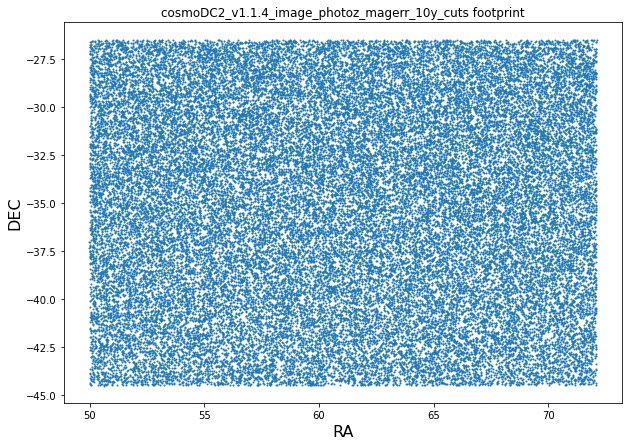

In [99]:
plt.figure(figsize=(10,7))
plt.scatter(gc_table['ra_true'][::1000], gc_table['dec_true'][::1000], s=1)
plt.title('cosmoDC2_v1.1.4_image_photoz_magerr_10y_cuts footprint')
plt.xlabel('RA', fontsize=16)
plt.ylabel('DEC', fontsize=16);

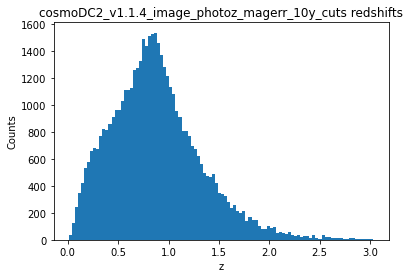

In [101]:
plt.hist(gc_table['redshift_true'][::1000], bins=100)
plt.title('cosmoDC2_v1.1.4_image_photoz_magerr_10y_cuts')
plt.xlabel('Redshift')
plt.ylabel('Counts');

Recast data into Pandas DF:

In [102]:
gc_df = pd.DataFrame(np.array(gc_table))

Add a digitized redshift column:

In [19]:
nzbins = 10
zbins = np.percentile(gc_df['redshift'], np.linspace(0, 100, nzbins + 1))
zbins[-1] += 1
iz = np.digitize(gc_df['redshift'], zbins) - 1
assert np.all((iz >= 0) & (iz < nzbins))
gc_df['iz'] = iz

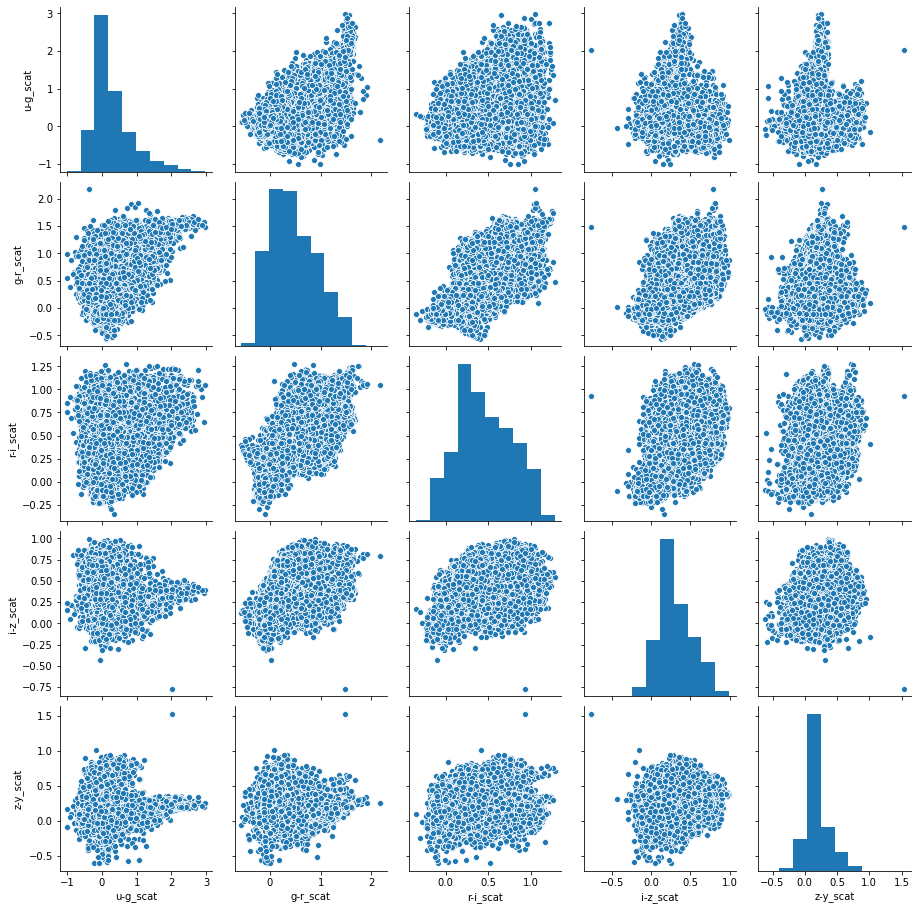

In [24]:
# Magnitude cuts look reasonable...
sns.pairplot(gc_df[['u-g_scat', 'g-r_scat', 'r-i_scat', 'i-z_scat', 'z-y_scat']][::2000]);

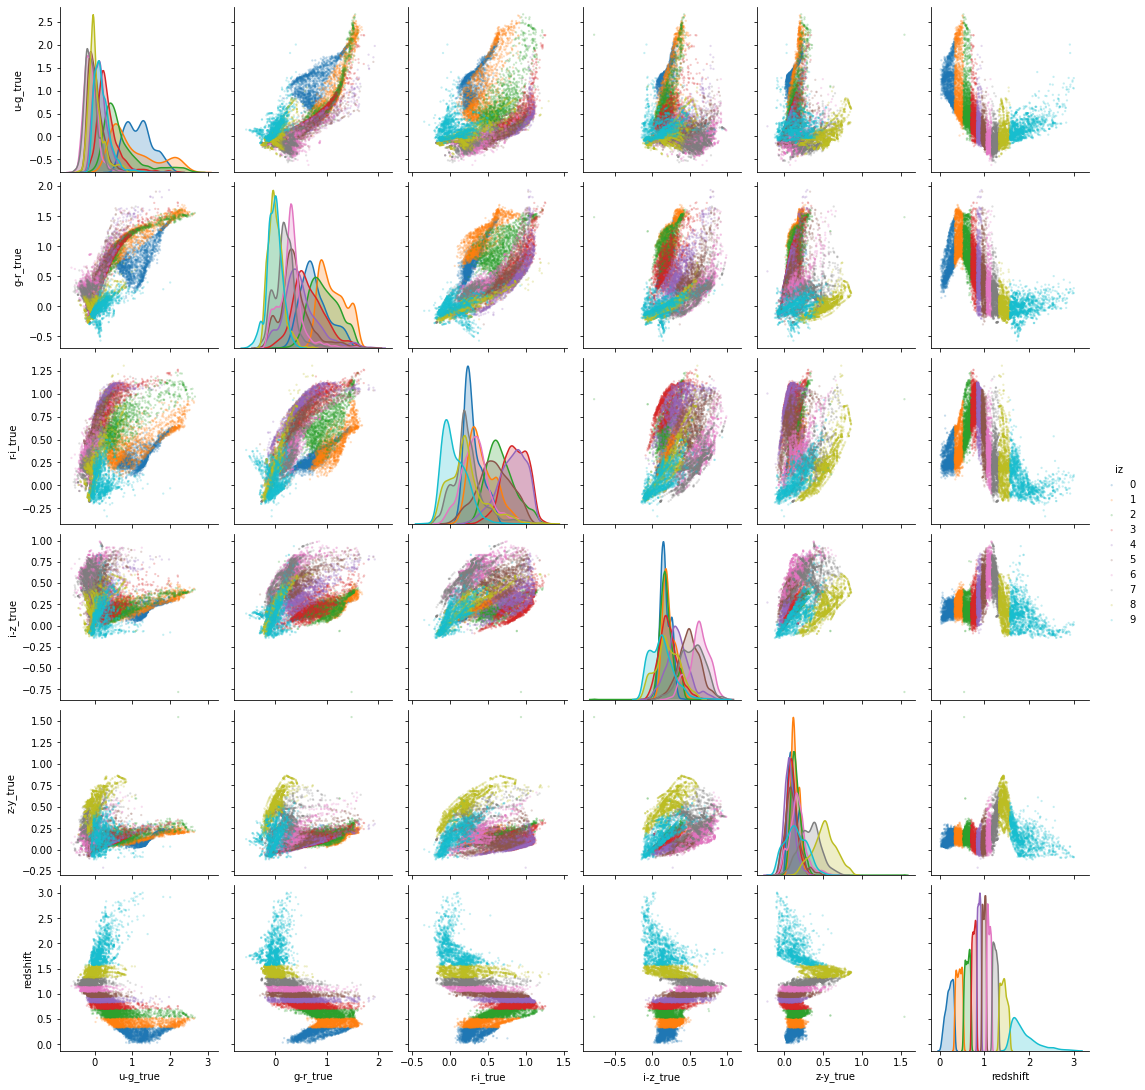

In [25]:
sns.pairplot(gc_df[::2000], vars=['u-g_true', 'g-r_true', 'r-i_true', 'i-z_true', 'z-y_true', 'redshift'],
             hue='iz', plot_kws=dict(edgecolor='none', alpha=0.25, s=5), diag_kind='kde');

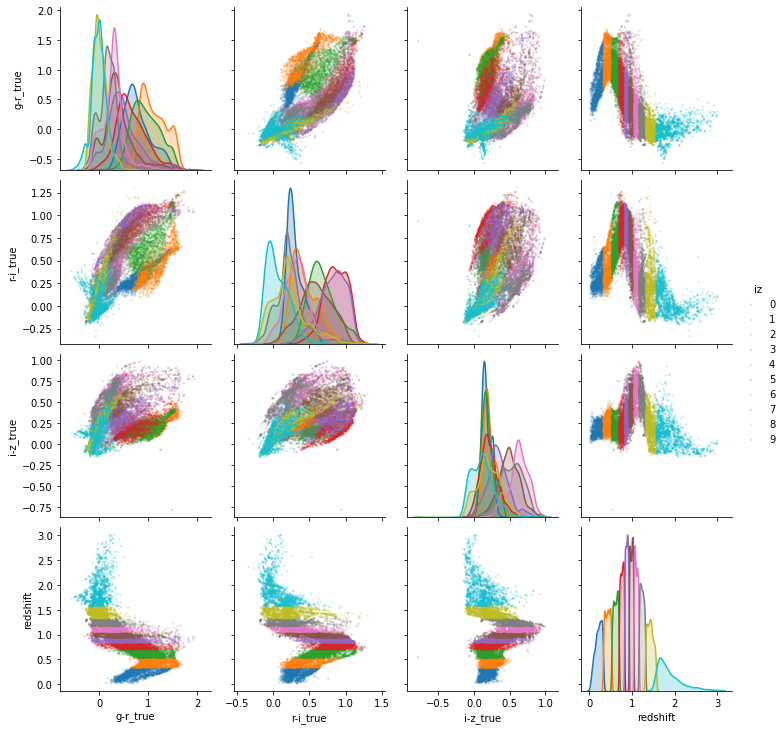

In [26]:
sns.pairplot(gc_df[['g-r_true', 'r-i_true', 'i-z_true', 'redshift', 'iz']][::2000], vars=['g-r_true', 'r-i_true', 'i-z_true', 'redshift'],
             hue='iz', plot_kws=dict(edgecolor='none', alpha=0.25, s=5), diag_kind='kde');

In [8]:
colors_table = Table([gc_table['u-g_true'], gc_table['g-r_true'], gc_table['r-i_true'], gc_table['i-z_true'], 
                      gc_table['z-y_true'], gc_table['redshift']], 
                   names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'redshift'])

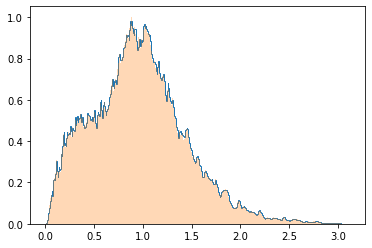

In [24]:
plt.hist(colors_table['redshift'], bins=500, histtype='step', density=True)
plt.hist(colors_table['redshift'][::20], bins=500, density=True, alpha=0.3);

Split data into train, validation and test sets:

In [33]:
def split(x, train_size, random_state):

    # Assert valid values for train size
    assert np.logical_and(train_size > 0., train_size < 1.)
    
    N = len(x)
    ntrain = int(train_size * N)
    
    # Generate random indices 
    random_indices = random_state.choice(N, N, replace=False)
    
    # Get train and test indices
    train_indices = random_indices[:ntrain]
    test_indices = random_indices[ntrain:]
    
    return(x[train_indices], x[test_indices])

In [42]:
colors_table = colors_table[::20]

In [43]:
train, test = split(colors_table, 0.8, rng)

In [44]:
len(train), len(test)

(1303670, 325918)

Look at redshift values for each set:

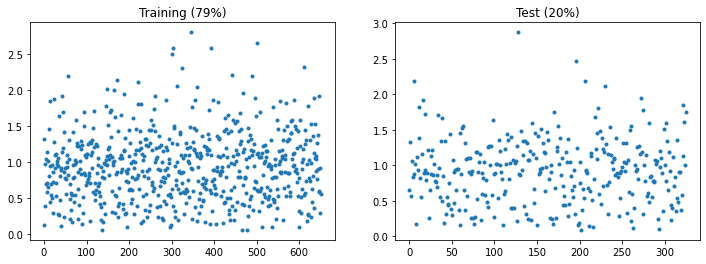

In [45]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs = axs.ravel()

axs[0].plot(train['redshift'][::2000], '.')
axs[0].set_title('Training ({}%)'.format(int(len(train) / len(colors_table) * 100)))
axs[1].plot(test['redshift'][::1000], '.')
axs[1].set_title('Test ({}%)'.format(int(len(test) / len(colors_table) * 100)));

Train SOM on training set:

In [47]:
nside = -30
niter = 10
ngals = 140000

In [48]:
X = train[['u-g', 'g-r', 'r-i', 'i-z', 'z-y']]
Y = np.asarray(train['redshift'])

Try: slower learning rate, more iterations?

For training set of size 65334 galaxies:

- 50 iterations takes 24 seconds (15 x 15 grid): max galaxies / cell around 200
- 90 iterations takes 42 seconds (15 x 15 grid): max gals / cell around 170
- 100 iterations takes 47 seconds (same): max gals / cell around 250
- 30 iterations takes 38 seconds (30 x 30 grid): max gals / cell around 50
- 90 iterations takes 70 seconds (30 x 30 grid): max gals / cell around 50
- 120 iterations takes 93 seconds (30 x 30 grid): max gals / cell around 50

For training set of size 1129234 galaxies:
- 30 iterations takes 3298 seconds (30 x 30 grid): max gals / cell around 6000

In [54]:
X.colnames

['u-g', 'g-r', 'r-i', 'i-z', 'z-y']

In [49]:
start = time.time()
som_train = som.SelfOrganizingMap(som.Grid(nside, nside))
som_train.fit(X, Y, maxiter=niter)
#som_train.map_to_som(X, Y)
print(time.time() - start)

1319.0971524715424


/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


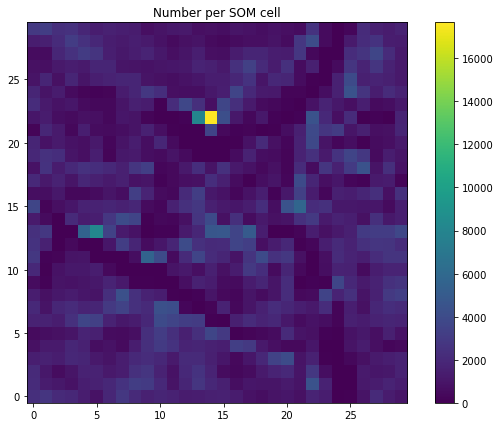

In [50]:
som_train.plot_counts_per_cell()

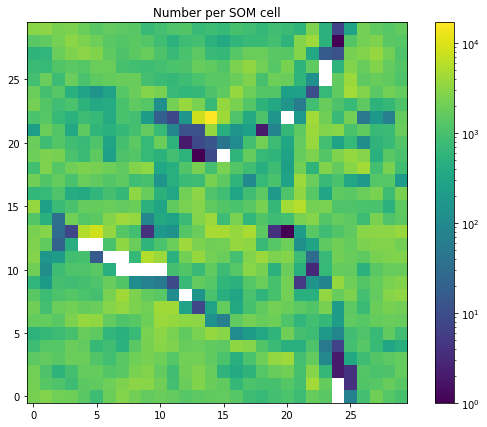

In [51]:
som_train.plot_counts_per_cell(norm=LogNorm(vmin=1, vmax=17000))

../python/som.py:342: RuntimeWarning: Mean of empty slice
  stat = np.asarray([statistic(self._target_dist[i]) for i in range(self._mapgeom.size)])


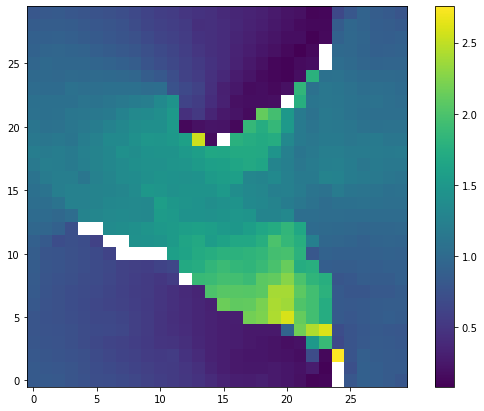

In [52]:
# Need to handle empty cells
som_train.plot_statistic(statistic=np.nanmean)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


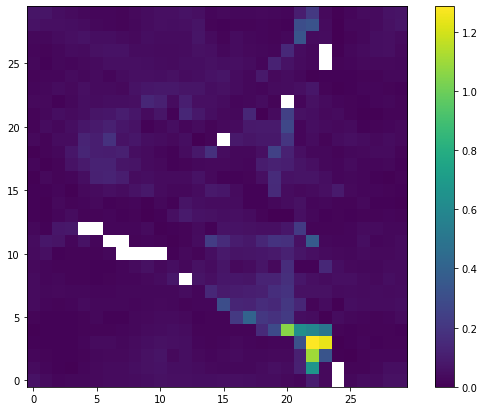

In [53]:
som_train.plot_statistic(statistic=np.nanstd)

../python/som.py:332: RuntimeWarning: Mean of empty slice
  stat = np.asarray([statistic(self._feature_dist[i][:,feature]) for i in range(self._mapgeom.size)])
../python/som.py:336: RuntimeWarning: Mean of empty slice
  diff = np.asarray([statistic(self._feature_dist[i] - self._weights.T[i], axis=0)[feature] for i in range(self._mapgeom.size)])


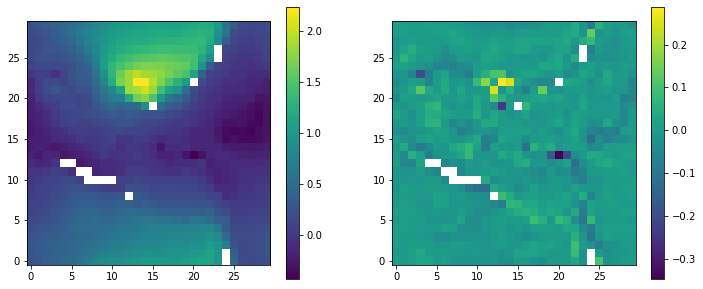

In [55]:
som_train.plot_statistic(feature=[0], statistic=np.nanmean)

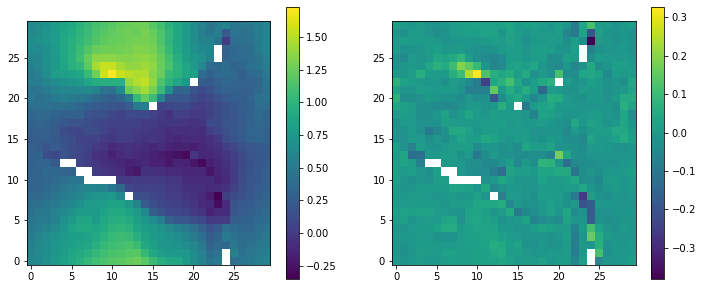

In [56]:
som_train.plot_statistic(feature=[1], statistic=np.nanmean)

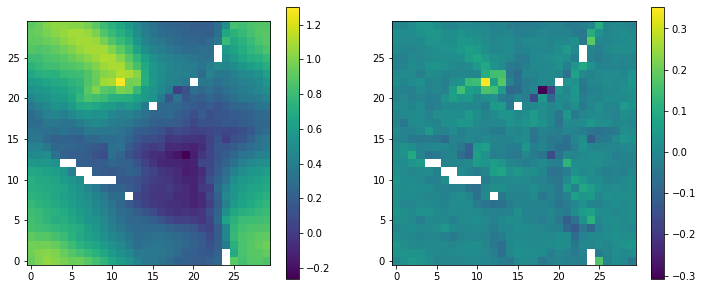

In [57]:
som_train.plot_statistic(feature=[2], statistic=np.nanmean)

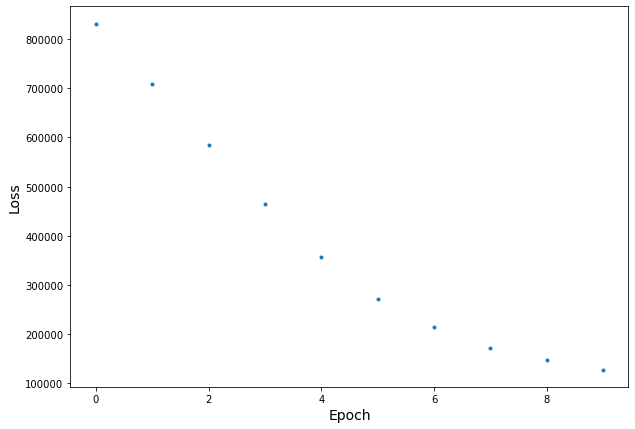

In [58]:
plt.figure(figsize=(10,7))
plt.plot(som_train._loss, '.')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14);

In [80]:
temp = np.zeros(10, dtype=np.float32)

In [81]:
temp[:] = X['u-g'][:10]

In [82]:
temp

array([ 1.084158  , -0.0585289 , -0.04166985,  0.38656807,  0.2453537 ,
        0.19965172,  0.7002773 ,  0.4443779 , -0.12573051,  0.11995316],
      dtype=float32)

In [73]:
np.array([3.234234], dtype=np.float32)

array([3.234234], dtype=float32)

In [75]:
X[:4]

u-g,g-r,r-i,i-z,z-y
float64,float64,float64,float64,float64
1.084157943725586,0.30470848083496094,0.1255817413330078,0.06224822998046875,0.022243499755859375
-0.058528900146484375,-0.1317291259765625,-0.06014251708984375,0.12811660766601562,0.3206920623779297
-0.04166984558105469,-0.09566307067871094,0.1560840606689453,0.114715576171875,0.439849853515625
0.3865680694580078,0.7695903778076172,1.025777816772461,0.41548919677734375,0.07048225402832031


In [61]:
pred = [np.mean(som_train._target_dist[best]) for best in som_train.find_bmu(som.table_to_array(X))]
rms = [np.std(som_train._target_dist[best]) for best in som_train.find_bmu(som.table_to_array(X))]

MemoryError: Unable to allocate 43.7 GiB for an array with shape (1303670, 5, 900) and data type float64

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(Y, pred, s=1)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

In [ ]:
chunks = 50
plt.figure(figsize=(8,6))
plt.errorbar(x=Y[::chunks], y=pred[::chunks], yerr=rms[::chunks], fmt='.', alpha=0.3)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

In [ ]:
plt.figure(figsize=(10,7))
plt.hexbin(Y, pred, gridsize=(50,50))
plt.colorbar();

Look at histogram of redshift distributions for a select subset of cells:

In [ ]:
# Give all cells the same binning
bb = np.linspace(0, 3.2, 100)

plt.figure(figsize=(10,7))
plt.hist(som_train._target_dist[0],   bins=bb, histtype='step', label='cell 0')
plt.hist(som_train._target_dist[290], bins=bb, histtype='step', label='cell 290')
plt.hist(som_train._target_dist[315], bins=bb, histtype='step', label='cell 315')
plt.hist(som_train._target_dist[361], bins=bb, histtype='step', label='cell 361')
plt.hist(som_train._target_dist[600], bins=bb, histtype='step', label='cell 600')
plt.hist(som_train._target_dist[800], bins=bb, histtype='step', label='cell 800')
plt.xlabel('z', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend();

Map test set back to SOM:

In [61]:
X_test = test[['g-r', 'r-i', 'i-z']][ngals:ngals+60000]
Y_test = np.asarray(test['redshift'])[ngals:ngals+60000]

In [62]:
len(X_test)

60000

In [46]:
som_train.map_to_som(X_test,Y_test)

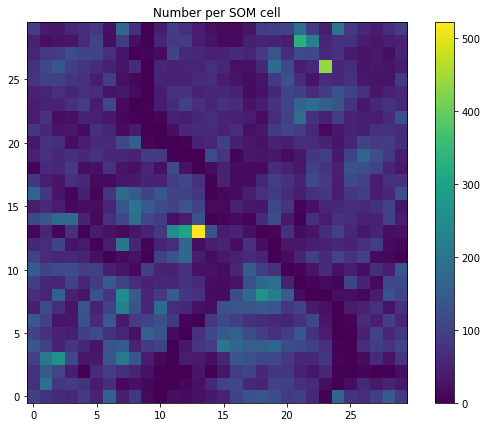

In [47]:
som_train.plot_counts_per_cell()

In [48]:
bmus = som_train.find_bmu(som.table_to_array(X_test))

In [49]:
pred = [np.mean(som_train._target_dist[bmus[i]]) for i in range(len(bmus))]
rms = [np.std(som_train._target_dist[bmus[i]]) for i in range(len(bmus))]

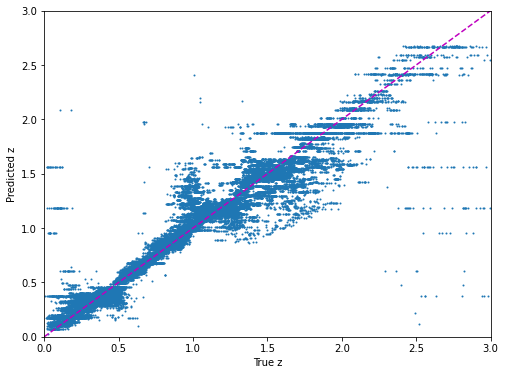

In [50]:
plt.figure(figsize=(8,6))
plt.scatter(Y_test, pred, s=1)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

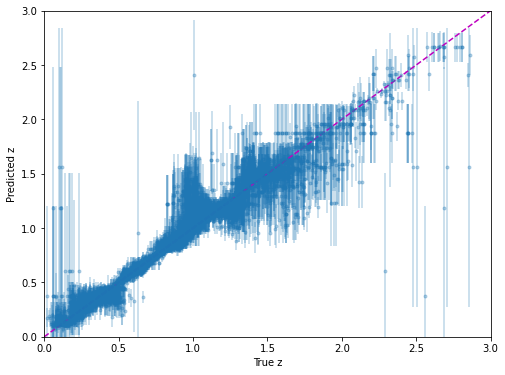

In [51]:
chunks = 10
plt.figure(figsize=(8,6))
plt.errorbar(x=Y_test[::chunks], y=pred[::chunks], yerr=rms[::chunks], fmt='.', alpha=0.3)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

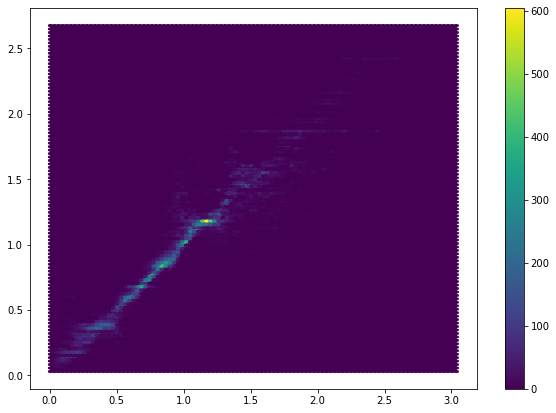

In [52]:
plt.figure(figsize=(10,7))
plt.hexbin(Y_test, pred, gridsize=(100,100))
plt.colorbar();

Compare to SOMz:

In [15]:
# This is lifted from the SOMz module from: http://matias-ck.com/mlz/somz.html

def get_index(ix, iy, nx, ny):
    return iy * nx + ix


def get_pair(ii, nx, ny):
    iy = int(numpy.floor(ii / nx))
    ix = ii % nx
    return ix, iy


def get_ns(ix, iy, nx, ny, index=False):
    """
    Get neighbors for rectangular grid given its
    coordinates and size of grid

    :param int ix: Coordinate in the x-axis
    :param int iy: Coordinate in the y-axis
    :param int nx: Number fo cells along the x-axis
    :param int ny: Number fo cells along the y-axis
    :param bool index: Return indexes in the map format
    :return: Array of indexes for direct neighbors
    """
    ns = []
    if ix - 1 >= 0: ns.append((ix - 1, iy))
    if iy - 1 >= 0: ns.append((ix, iy - 1))
    if ix + 1 < nx: ns.append((ix + 1, iy))
    if iy + 1 < ny: ns.append((ix, iy + 1))

    if ix - 1 >= 0 and iy - 1 >= 0: ns.append((ix - 1, iy - 1))
    if ix - 1 >= 0 and iy + 1 < ny: ns.append((ix - 1, iy + 1))
    if ix + 1 < nx and iy + 1 < ny: ns.append((ix + 1, iy + 1))
    if ix + 1 < nx and iy - 1 >= 0: ns.append((ix + 1, iy - 1))

    ns = numpy.array(ns)
    if not index:
        return ns
    if index:
        ins = []
        for i in range(len(ns)):
            ins.append(get_index(ns[i, 0], ns[i, 1], nx, ny))
        return numpy.array(ins)


def get_ns_hex(ix, iy, nx, ny, index=False):
    """
    Get neighbors for hexagonal grid given its coordinates
    and size of grid
    Same parameters as :func:`get_ns`
    """
    ns = []
    even = False
    if iy % 2 == 0: even = True
    if ix - 1 >= 0: ns.append((ix - 1, iy))
    if ix + 1 < nx: ns.append((ix + 1, iy))
    if iy - 1 >= 0: ns.append((ix, iy - 1))
    if iy + 1 < ny: ns.append((ix, iy + 1))
    if even and ix - 1 >= 0 and iy - 1 >= 0: ns.append((ix - 1, iy - 1))
    if even and ix - 1 >= 0 and iy + 1 < ny: ns.append((ix - 1, iy + 1))
    if not even and ix + 1 < nx and iy - 1 >= 0: ns.append((ix + 1, iy - 1))
    if not even and ix + 1 < nx and iy + 1 < ny: ns.append((ix + 1, iy + 1))
    ns = numpy.array(ns)
    if not index:
        return ns
    if index:
        ins = []
        for i in range(len(ns)):
            ins.append(get_index(ns[i, 0], ns[i, 1], nx, ny))
        return numpy.array(ins)


def geometry(top, Ntop, periodic='no'):
    """
    Pre-compute distances between cells in a given topology
    and store it on a distLib array

    :param str top: Topology ('grid','hex','sphere')
    :param int Ntop: Size of map,  for grid Size=Ntop*Ntop,
        for hex Size=Ntop*(Ntop+1[2]) if Ntop is even[odd] and for sphere
        Size=12*Ntop*Ntop and top must be power of 2
    :param str periodic: Use periodic boundary conditions ('yes'/'no'), valid for 'hex' and 'grid' only
    :return: 2D array with distances pre computed between cells and total number of units
    :rtype: 2D float array, int
    """
    if top == 'sphere':
        try:
            import healpy as hpx
        except:
            print('Error: healpy module not found, use grid or hex topologies')
            sys.exit(0)
    if top == 'sphere':
        nside = Ntop
        npix = 12 * nside ** 2
        distLib = numpy.zeros((npix, npix))
        for i in range(npix):
            ai = hpx.pix2ang(nside, i)
            for j in range(i + 1, npix):
                aj = hpx.pix2ang(nside, j)
                distLib[i, j] = hpx.rotator.angdist(ai, aj)
                distLib[j, i] = distLib[i, j]
        distLib[numpy.where(numpy.isnan(distLib))] = numpy.pi
    if top == 'grid':
        nx = Ntop
        ny = Ntop
        npix = nx * ny
        mapxy = numpy.mgrid[0:1:complex(0, nx), 0:1:complex(0, ny)]
        mapxy = numpy.reshape(mapxy, (2, npix))
        bX = mapxy[1]
        bY = mapxy[0]
        dx = 1. / (nx - 1)
        dy = 1. / (ny - 1)
        distLib = numpy.zeros((npix, npix))
        if periodic == 'no':
            for i in range(npix):
                for j in range(i + 1, npix):
                    distLib[i, j] = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    distLib[j, i] = distLib[i, j]
        if periodic == 'yes':
            for i in range(npix):
                for j in range(i + 1, npix):
                    s0 = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    s1 = numpy.sqrt((bX[i] - (bX[j] + 1. + dx)) ** 2 + (bY[i] - bY[j]) ** 2)
                    s2 = numpy.sqrt((bX[i] - (bX[j] + 1. + dx)) ** 2 + (bY[i] - (bY[j] + 1. + dy)) ** 2)
                    s3 = numpy.sqrt((bX[i] - (bX[j] + 0.)) ** 2 + (bY[i] - (bY[j] + 1. + dy)) ** 2)
                    s4 = numpy.sqrt((bX[i] - (bX[j] - 1. - dx)) ** 2 + (bY[i] - (bY[j] + 1. + dy)) ** 2)
                    s5 = numpy.sqrt((bX[i] - (bX[j] - 1. - dx)) ** 2 + (bY[i] - (bY[j] + 0.)) ** 2)
                    s6 = numpy.sqrt((bX[i] - (bX[j] - 1. - dx)) ** 2 + (bY[i] - (bY[j] - 1. - dy)) ** 2)
                    s7 = numpy.sqrt((bX[i] - (bX[j] + 0.)) ** 2 + (bY[i] - (bY[j] - 1. - dy)) ** 2)
                    s8 = numpy.sqrt((bX[i] - (bX[j] + 1. + dx)) ** 2 + (bY[i] - (bY[j] - 1. - dy)) ** 2)
                    distLib[i, j] = numpy.min((s0, s1, s2, s3, s4, s5, s6, s7, s8))
                    distLib[j, i] = distLib[i, j]
    if top == 'hex':
        nx = Ntop
        ny = Ntop
        xL = numpy.arange(0, nx, 1.)
        dy = 0.8660254
        yL = numpy.arange(0, ny, dy)
        ny = len(yL)
        nx = len(xL)
        npix = nx * ny
        bX = numpy.zeros(nx * ny)
        bY = numpy.zeros(nx * ny)
        kk = 0
        last = ny * dy
        for jj in range(ny):
            for ii in range(nx):
                if jj % 2 == 0: off = 0.
                if jj % 2 == 1: off = 0.5
                bX[kk] = xL[ii] + off
                bY[kk] = yL[jj]
                kk += 1
        distLib = numpy.zeros((npix, npix))
        if periodic == 'no':
            for i in range(npix):
                for j in range(i + 1, npix):
                    distLib[i, j] = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    distLib[j, i] = distLib[i, j]
        if periodic == 'yes':
            for i in range(npix):
                for j in range(i + 1, npix):
                    s0 = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    s1 = numpy.sqrt((bX[i] - (bX[j] + nx)) ** 2 + (bY[i] - bY[j]) ** 2)
                    s2 = numpy.sqrt((bX[i] - (bX[j] + nx)) ** 2 + (bY[i] - (bY[j] + last)) ** 2)
                    s3 = numpy.sqrt((bX[i] - (bX[j] + 0)) ** 2 + (bY[i] - (bY[j] + last)) ** 2)
                    s4 = numpy.sqrt((bX[i] - (bX[j] - nx)) ** 2 + (bY[i] - (bY[j] + last)) ** 2)
                    s5 = numpy.sqrt((bX[i] - (bX[j] - nx)) ** 2 + (bY[i] - (bY[j] + 0)) ** 2)
                    s6 = numpy.sqrt((bX[i] - (bX[j] - nx)) ** 2 + (bY[i] - (bY[j] - last)) ** 2)
                    s7 = numpy.sqrt((bX[i] - (bX[j] + 0)) ** 2 + (bY[i] - (bY[j] - last)) ** 2)
                    s8 = numpy.sqrt((bX[i] - (bX[j] + nx)) ** 2 + (bY[i] - (bY[j] - last)) ** 2)
                    distLib[i, j] = numpy.min((s0, s1, s2, s3, s4, s5, s6, s7, s8))
                    distLib[j, i] = distLib[i, j]
    return distLib, npix


def is_power_2(value):
    """
    Check if passed value is a power of 2
    """
    return value!=0 and ((value & (value- 1)) == 0)


def get_alpha(t, alphas, alphae, NT):
    """
    Get value of alpha at a given time
    """
    return alphas * numpy.power(alphae / alphas, float(t) / float(NT))


def get_sigma(t, sigma0, sigmaf, NT):
    """
    Get value of sigma at a given time
    """
    return sigma0 * numpy.power(sigmaf / sigma0, float(t) / float(NT))


def h(bmu, mapD, sigma):
    """
    Neighborhood function which quantifies how much cells around the best matching one are modified

    :param int bmu: best matching unit
    :param float mapD: array of distances computed with :func:`geometry`
    """
    return numpy.exp(-(mapD[bmu] ** 2) / sigma ** 2)

In [16]:
class SelfMap():
    """
    Create a som class instance

    :param float X: Attributes array (all columns used)
    :param float Y: Attribute to be predicted (not really needed, can be zeros)
    :param str topology: Which 2D topology, 'grid', 'hex' or 'sphere'
    :param str som_type: Which updating scheme to use 'online' or 'batch'
    :param int Ntop: Size of map,  for grid Size=Ntop*Ntop,
        for hex Size=Ntop*(Ntop+1[2]) if Ntop is even[odd] and for sphere
        Size=12*Ntop*Ntop and top must be power of 2
    :param  int iterations: Number of iteration the entire sample is processed
    :param str periodic: Use periodic boundary conditions ('yes'/'no'), valid for 'hex' and 'grid' only
    :param dict dict_dim: dictionary with attributes names
    :param float astar: Initial value of alpha
    :param float aend: End value of alpha
    :param str importance: Path to the file with importance ranking for attributes, default is none
    """

    def __init__(self, X, Y, topology='grid', som_type='online', Ntop=28, iterations=30, periodic='no', dict_dim='',
                 astart=0.8, aend=0.5, importance=None):
        self.np, self.nDim = numpy.shape(X)
        self.dict_dim = dict_dim
        self.X = X
        self.Y = Y
        self.aps = astart
        self.ape = aend
        self.top = topology
        if topology=='sphere' and not is_power_2(Ntop):
            print('Error, Ntop must be power of 2')
            sys.exit(0)
        self.stype = som_type
        self.Ntop = Ntop
        self.nIter = iterations
        self.per = periodic
        self.distLib, self.npix = geometry(self.top, self.Ntop, periodic=self.per)
        if importance == None: importance = numpy.ones(self.nDim)
        self.importance = importance / numpy.sum(importance)
        # Added
        #self.store_weights = np.empty((self.nIter, self.np, self.nDim, self.npix))
        self.loss = np.empty(self.nIter)

    def som_best_cell(self, inputs, return_vals=1):
        """
        Return the closest cell to the input object
        It can return more than one value if needed
        """
        activations = numpy.sum(numpy.transpose([self.importance]) * (
            numpy.transpose(numpy.tile(inputs, (self.npix, 1))) - self.weights) ** 2, axis=0)
        if return_vals == 1:
            best = numpy.argmin(activations)
            return best, activations
        else:
            best_few = numpy.argsort(activations)
            return best_few[0:return_vals], activations

    def create_map(self, evol='no', inputs_weights='', seed=123):
        """
        This is same as above but uses python routines instead
        """
        
        # Added
        rng = np.random.RandomState(seed=seed)
        
        if inputs_weights == '':
            # Added
            self.weights = rng.random_sample(size=(self.nDim, self.npix)) + self.X[0][0]
            #self.weights = (numpy.random.rand(self.nDim, self.npix)) + self.X[0][0]
        else:
            self.weights = inputs_weights
        self.NT = self.nIter * self.np
        if self.stype == 'online':
            tt = 0
            sigma0 = self.distLib.max()
            sigma_single = numpy.min(self.distLib[numpy.where(self.distLib > 0.)])
            # Added
            #self.store_weights = np.empty((self.nIter, self.np, self.nDim, self.npix))
            for it in range(self.nIter):
                #get alpha, sigma
                alpha = get_alpha(tt, self.aps, self.ape, self.NT)
                sigma = get_sigma(tt, sigma0, sigma_single, self.NT)
                #index_random = random.sample(range(self.np), self.np)
                # Added
                index_random = rng.choice(np.arange(self.np), size=self.np, replace=False)
                loss = 0.
                for i in range(self.np):
                    tt += 1
                    inputs = self.X[index_random[i]]
                    # Added
                    #inputs = self.X[i]
                    best, activation = self.som_best_cell(inputs)
                    dx = numpy.transpose(
                        (inputs - numpy.transpose(self.weights)))
                    loss += np.sqrt(np.sum(dx ** 2, axis=0))[best]
                    self.weights += alpha * h(best, self.distLib, sigma) * dx
                    # Added
                    #self.store_weights[it,i] = self.weights
                self.loss[it] = loss
                if evol == 'yes':
                    self.evaluate_map()
                    self.save_map(itn=it)
        if self.stype == 'batch':
            tt = 0
            sigma0 = self.distLib.max()
            sigma_single = numpy.min(self.distLib[numpy.where(self.distLib > 0.)])
            for it in range(self.nIter):
                #get alpha, sigma
                sigma = get_sigma(tt, sigma0, sigma_single, self.NT)
                accum_w = numpy.zeros((self.nDim, self.npix))
                accum_n = numpy.zeros(self.npix)
                for i in range(self.np):
                    tt += 1
                    inputs = self.X[i]
                    best, activation = self.som_best_cell(inputs)
                    for kk in range(self.nDim):
                        accum_w[kk, :] += h(best, self.distLib, sigma) * inputs[kk]
                    accum_n += h(best, self.distLib, sigma)
                for kk in range(self.nDim):
                    self.weights[kk] = accum_w[kk] / accum_n

                if evol == 'yes':
                    self.evaluate_map()
                    self.save_map(itn=it)

    def evaluate_map(self, inputX='', inputY=''):
        """
        This functions evaluates the map created using the input Y or a new Y (array of labeled attributes)
        It uses the X array passed or new data X as well, the map doesn't change

        :param float inputX: Use this if another set of values for X is wanted using
            the weigths already computed
        :param float inputY: One  dimensional array of the values to be assigned to each cell in the map
            based on the in-memory X passed
        """
        self.yvals = {}
        self.ivals = {}
        if inputX == '':
            inX = self.X
        else:
            inX = inputX
        if inputY == '':
            inY = self.Y
        else:
            inY = inputY
        for i in range(len(inX)):
            inputs = inX[i]
            best, activation = self.som_best_cell(inputs)
            if not best in self.yvals: self.yvals[best] = []
            self.yvals[best].append(inY[i])
            if not best in self.ivals: self.ivals[best] = []
            self.ivals[best].append(i)

    def get_vals(self, line):
        """
        Get the predictions  given a line search, where the line
        is a vector of attributes per individual object fot the
        10 closest cells.

        :param float line: input data to look in the tree
        :return: array with the cell content
        """
        best, act = self.som_best_cell(line, return_vals=10)
        for ib in range(10):
            if best[ib] in self.yvals: return self.yvals[best[ib]]
        return numpy.array([-1.])

    def get_best(self, line):
        """
        Get the predictions  given a line search, where the line
        is a vector of attributes per individual object for THE best cell

        :param float line: input data to look in the tree
        :return: array with the cell content
        """
        best, act = self.som_best_cell(line, return_vals=10)
        return best[0]

    def save_map(self, itn=-1, fileout='SOM', path=''):
        """
        Saves the map

        :param int itn: Number of map to be included on path, use -1 to ignore this number
        :param str fileout: Name of output file
        :param str path: path for the output file
        """
        if path == '':
            path = os.getcwd() + '/'
        if not os.path.exists(path): os.system('mkdir -p ' + path)
        if itn >= 0:
            ff = '_%04d' % itn
            fileout += ff
        numpy.save(path + fileout, self)

    def save_map_dict(self, path='', fileout='SOM', itn=-1):
        """
        Saves the map in dictionary format

        :param int itn: Number of map to be included on path, use -1 to ignore this number
        :param str fileout: Name of output file
        :param str path: path for the output file
        """
        SOM = {}
        SOM['W'] = self.weights
        SOM['yvals'] = self.yvals
        SOM['ivals'] = self.ivals
        SOM['topology'] = self.top
        SOM['Ntop'] = self.Ntop
        SOM['npix'] = self.npix
        if path == '':
            path = os.getcwd() + '/'
        if not os.path.exists(path): os.system('mkdir -p ' + path)
        if itn > 0:
            ff = '_%04d' % itn
            fileout += ff
        numpy.save(path + fileout, SOM)

    def plot_map(self, min_m=-100, max_m=-100, colbar='yes'):
        """
        Plots the map after evaluating, the cells are colored with the mean value inside each
        one of them

        :param float min_m: Lower limit for coloring the cells, -100 uses min value
        :param float max_m: Upper limit for coloring the cells, -100 uses max value
        :param str colbar: Include a colorbar ('yes','no')
        """

        import matplotlib.pyplot as plt
        #from matplotlib import mpl
        # see https://stackoverflow.com/questions/44499971/importerror-cannot-import-name-mpl-from-matplotlib-import-mpl
        import matplotlib as mpl
        import matplotlib.cm as cm
        from matplotlib import collections, transforms
        from matplotlib.colors import colorConverter

        if self.top == 'sphere': import healpy as H

        if self.top == 'grid':
            M = numpy.zeros(self.npix) - 20.
            S = numpy.zeros(self.npix)
            for i in range(self.npix):
                if i in self.yvals:
                    M[i] = numpy.mean(self.yvals[i])
                    S[i] = numpy.std(self.yvals[i])
            M2 = numpy.reshape(M, (self.Ntop, self.Ntop))
            S2 = numpy.reshape(S, (self.Ntop, self.Ntop))
            #plt.figure(figsize=(8, 8), dpi=100)
            fig, axs = plt.subplots(1,2, figsize=(12,5))
            axs = axs.ravel()
            if min_m == -100: min_m = M2[numpy.where(M2 > -10)].min()
            min_s = S2[numpy.where(S2 > -10)].min()
            if max_m == -100: max_m = M2.max()
            max_s = S2.max() 
            #SM2 = plt.imshow(M2, origin='center', interpolation='nearest', cmap=cm.jet, vmin=min_m, vmax=max_m)
            #SM2.cmap.set_under("grey")
            im0 = axs[0].imshow(M2, origin='lower', interpolation='none', cmap='viridis', vmin=min_m, vmax=max_m)
            im1 = axs[1].imshow(S2, origin='lower', interpolation='none', cmap='viridis', vmin=min_s, vmax=max_s)
            fig.colorbar(im0, ax=axs[0])
            fig.colorbar(im1, ax=axs[1])
            #if colbar == 'yes': plt.colorbar()
            plt.axis('off')
        if self.top == 'hex':
            nx = self.Ntop
            ny = self.Ntop
            xL = numpy.arange(0, nx, 1.)
            dy = 0.8660254
            yL = numpy.arange(0, ny, dy)
            ny = len(yL)
            nx = len(xL)
            npix = nx * ny
            bX = numpy.zeros(nx * ny)
            bY = numpy.zeros(nx * ny)
            kk = 0
            for jj in range(ny):
                for ii in range(nx):
                    if jj % 2 == 0: off = 0.
                    if jj % 2 == 1: off = 0.5
                    bX[kk] = xL[ii] + off
                    bY[kk] = yL[jj]
                    kk += 1
            xyo = list(zip(bX, bY))
            sizes_2 = numpy.zeros(nx * ny) + ((8. * 0.78 / (self.Ntop + 0.5)) / 2. * 72.) ** 2 * 4. * numpy.pi / 3.
            M = numpy.zeros(npix) - 20.
            fcolors = [plt.cm.Spectral_r(x) for x in numpy.random.rand(nx * ny)]
            for i in range(npix):
                if i in self.yvals:
                    M[i] = numpy.mean(self.yvals[i])
            if max_m == -100: max_m = M.max()
            if min_m == -100: min_m = M[numpy.where(M > -10)].min()
            M = M - min_m
            M = M / (max_m - min_m)
            for i in range(npix):
                if M[i] <= 0:
                    fcolors[i] = plt.cm.Greys(.5)
                else:
                    fcolors[i] = plt.cm.jet(M[i])
            figy = ((8. * 0.78 / (self.Ntop + 0.5) / 2.) * (3. * ny + 1) / numpy.sqrt(3)) / 0.78
            fig3 = plt.figure(figsize=(8, figy), dpi=100)
            #fig3.subplots_adjust(left=0,right=1.,top=1.,bottom=0.)
            a = fig3.add_subplot(1, 1, 1)
            col = collections.RegularPolyCollection(6, sizes=sizes_2, offsets=xyo, transOffset=a.transData)
            col.set_color(fcolors)
            a.add_collection(col, autolim=True)
            a.set_xlim(-0.5, nx)
            a.set_ylim(-1, nx + 0.5)
            plt.axis('off')
            if colbar == 'yes':
                figbar = plt.figure(figsize=(8, 1.), dpi=100)
                ax1 = figbar.add_axes([0.05, 0.8, 0.9, 0.15])
                cmap = cm.jet
                norm = mpl.colors.Normalize(vmin=min_m, vmax=max_m)
                cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='horizontal')
                cb1.set_label('')
        if self.top == 'sphere':
            M = numpy.zeros(self.npix) + H.UNSEEN
            for i in range(self.npix):
                if i in self.yvals:
                    M[i] = numpy.mean(self.yvals[i])
            plt.figure(10, figsize=(8, 8), dpi=100)
            if min_m == -100: min_m = M[numpy.where(M > -10)].min()
            if max_m == -100: max_m = M.max()
            if colbar == 'yes': H.mollview(M, fig=10, title="", min=min_m, max=max_m, cbar=True)
            if colbar == 'no': H.mollview(M, fig=10, title="", min=min_m, max=max_m, cbar=False)
        plt.show()

215.49448919296265


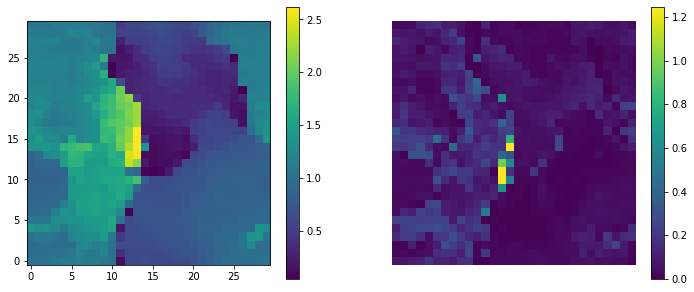

In [17]:
start = time.time()
M = SelfMap(som.table_to_array(X),Y,Ntop=nside,iterations=niter,periodic='yes')
M.create_map()
M.evaluate_map()
print(time.time() - start)
M.plot_map()

In [35]:
def plot_somz_counts():
    
    # Plot counts per cell
    counts = np.zeros(nside ** 2, dtype=int)
    for i in range(nside **2): 
        try:
            counts[i] = len(M.yvals[i])
        except KeyError:
            pass
        
    plt.figure(figsize=(10,7))
    plt.imshow(counts.reshape(nside,nside), origin='lower', cmap='viridis')
    plt.title('Number per SOM cell')
    plt.colorbar();
    
def plot_somz_loss():
    
    plt.figure(figsize=(10,7))
    plt.plot(M.loss, '.')
    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=14);
    
def plot_somz_feature(data, feature=0, statistic=np.nanmean):
    
    cell_stat = []
    cell_feature = []
    for i in range(nside ** 2):
        try:
            diff = data[M.ivals[i]] - M.weights.T[i]
            cell_stat.append(statistic(diff, axis=0)[feature])
        except KeyError:
            cell_stat.append(np.nan)
        try:
            cell_feature.append(statistic(data[M.ivals[i]], axis=0)[feature])
        except KeyError:
            cell_feature.append(np.nan)
            
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs = axs.ravel()
    
    im0 = axs[0].imshow(np.array(cell_feature).reshape(nside,nside), origin='lower', interpolation='none')
    #axs[0].set_title('Mean of feature {}'.format(feature))
    fig.colorbar(im0, ax=axs[0])
    
    im1 = axs[1].imshow(np.array(cell_stat).reshape(nside,nside), origin='lower', interpolation='none')
    #axs[1].set_title('Mean(data - node weights) for feature {}'.format(feature))
    fig.colorbar(im1, ax=axs[1])
    
    plt.show()

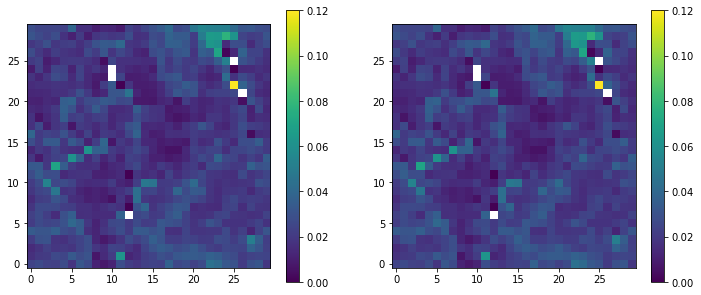

In [36]:
plot_somz_feature(som.table_to_array(X), feature=0, statistic=np.nanstd)

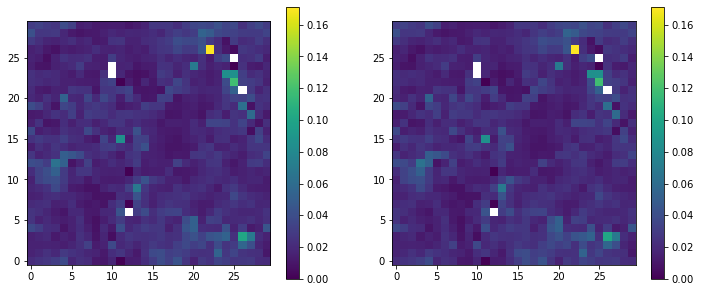

In [37]:
plot_somz_feature(som.table_to_array(X), feature=1, statistic=np.nanstd)

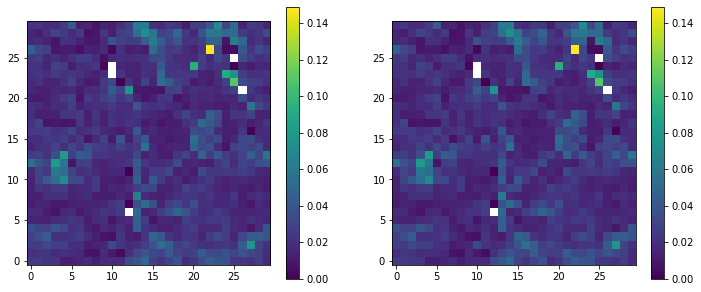

In [38]:
plot_somz_feature(som.table_to_array(X), feature=2, statistic=np.nanstd)

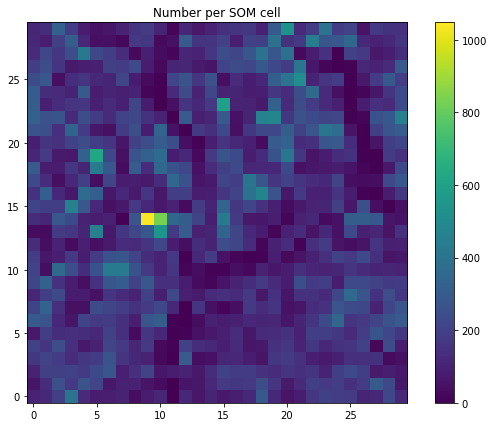

In [39]:
plot_somz_counts()

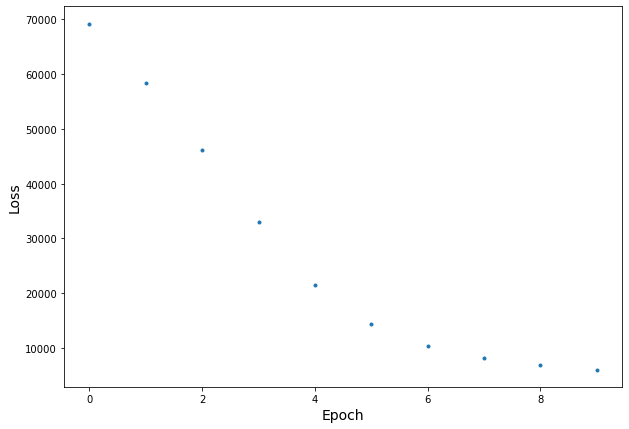

In [40]:
plot_somz_loss()

In [41]:
pred = [np.mean(M.get_vals(som.table_to_array(X)[i])) for i in range(len(X))]
rms = [np.std(M.get_vals(som.table_to_array(X)[i])) for i in range(len(X))]

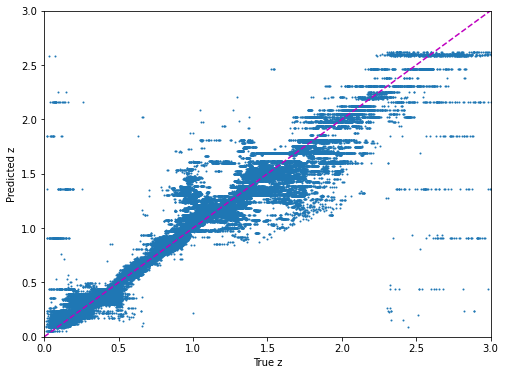

In [42]:
plt.figure(figsize=(8,6))
plt.scatter(Y, pred, s=1)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

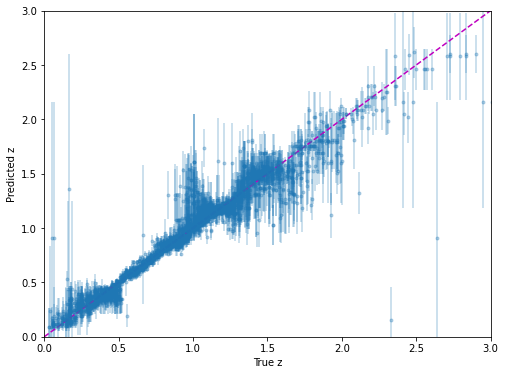

In [43]:
chunks = 50
plt.figure(figsize=(8,6))
plt.errorbar(x=Y[::chunks], y=pred[::chunks], yerr=rms[::chunks], fmt='.', alpha=0.3)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

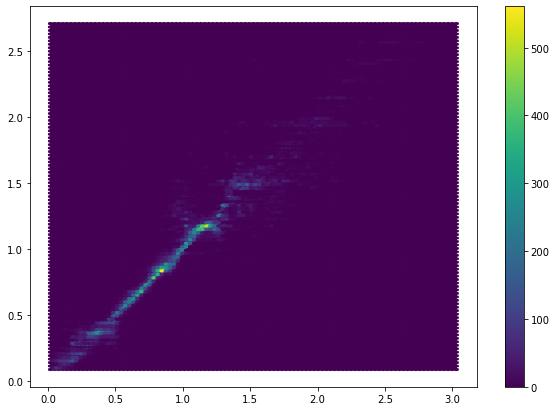

In [84]:
plt.figure(figsize=(10,7))
plt.hexbin(Y, pred, gridsize=(100,100))
plt.colorbar();

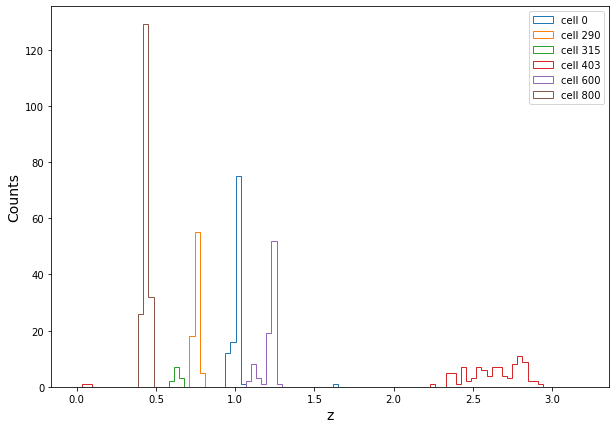

In [29]:
# Give all cells the same binning
bb = np.linspace(0, 3.2, 100)

plt.figure(figsize=(10,7))
plt.hist(M.yvals[0],   bins=bb, histtype='step', label='cell 0')
plt.hist(M.yvals[290], bins=bb, histtype='step', label='cell 290')
plt.hist(M.yvals[315], bins=bb, histtype='step', label='cell 315')
plt.hist(M.yvals[403], bins=bb, histtype='step', label='cell 403')
plt.hist(M.yvals[600], bins=bb, histtype='step', label='cell 600')
plt.hist(M.yvals[800], bins=bb, histtype='step', label='cell 800')
plt.xlabel('z', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend();

Map test data back to SOM:

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


3.450899362564087


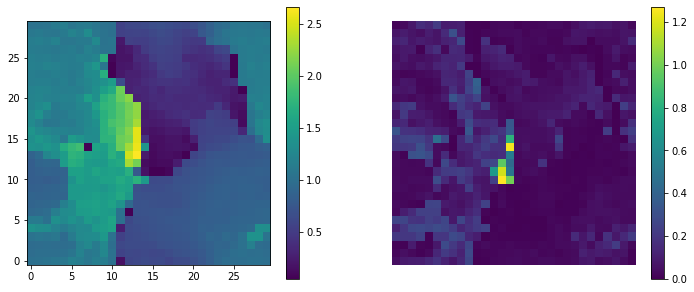

In [53]:
start = time.time()
M.evaluate_map(inputX=som.table_to_array(X_test), inputY=Y_test)
print(time.time() - start)
M.plot_map()

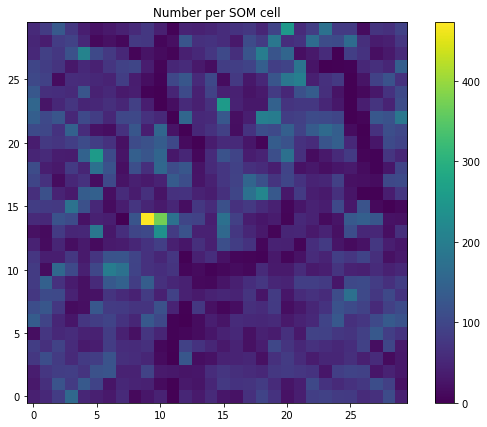

In [54]:
plot_somz_counts()

In [55]:
pred = [np.mean(M.get_vals(som.table_to_array(X_test)[i])) for i in range(len(X_test))]
rms = [np.std(M.get_vals(som.table_to_array(X_test)[i])) for i in range(len(X_test))]

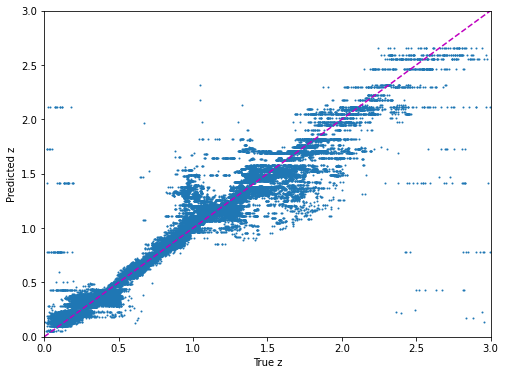

In [56]:
plt.figure(figsize=(8,6))
plt.scatter(Y_test, pred, s=1)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

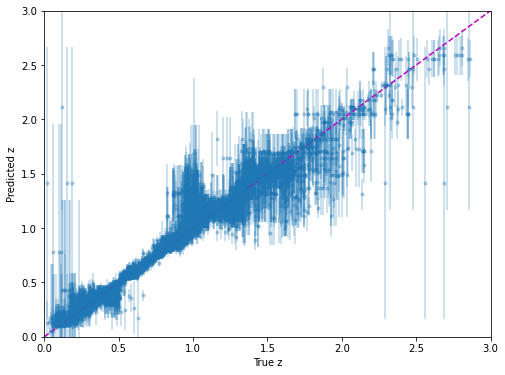

In [57]:
chunks = 10
plt.figure(figsize=(8,6))
plt.errorbar(x=Y_test[::chunks], y=pred[::chunks], yerr=rms[::chunks], fmt='.', alpha=0.3)
plt.plot([0,3], [0,3], '--m')
plt.xlabel('True z')
plt.ylabel('Predicted z')
plt.xlim(0,3)
plt.ylim(0,3);

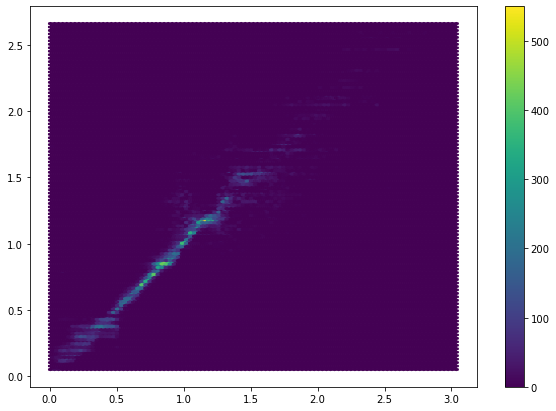

In [58]:
plt.figure(figsize=(10,7))
plt.hexbin(Y_test, pred, gridsize=(100,100))
plt.colorbar();

Updated 2D density plot:

In [63]:
start = time.time()
som_train = som.SelfOrganizingMap(som.Grid(-nside, -nside))
som_train.fit(X, Y, maxiter=niter)
print(time.time() - start)

115.45545506477356


In [255]:
nbins = 100
bins = np.linspace(0, 3, nbins + 1)

density = np.zeros((nbins, nbins))

train_dist = som_train._target_dist
test_dat = som.table_to_array(X_test)
best = som_train.find_bmu(test_dat)
test_dist = [Y_test[best == i] for i in range(som_train._mapgeom.size)]

for cell, dist in enumerate(train_dist):
    if dist.size == 0:
        pass
    else:
        test_hist, _ = np.histogram(test_dist[cell], bins)
        train_rho, _ = np.histogram(dist, bins, density=True)
        for zbin, nz in enumerate(test_hist):
            density[:, zbin] += nz * train_rho

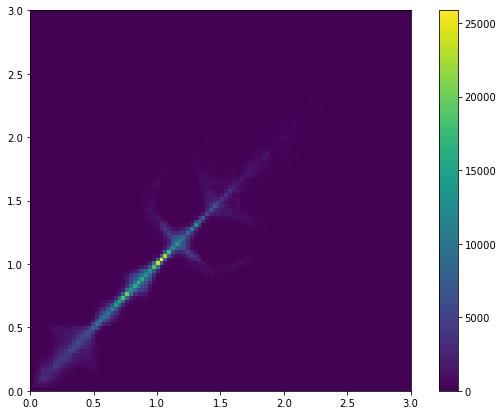

In [256]:
plt.figure(figsize=(10,7))
plt.imshow(density, origin='lower', extent=(bins[0], bins[-1], bins[0], bins[-1]))
plt.colorbar();

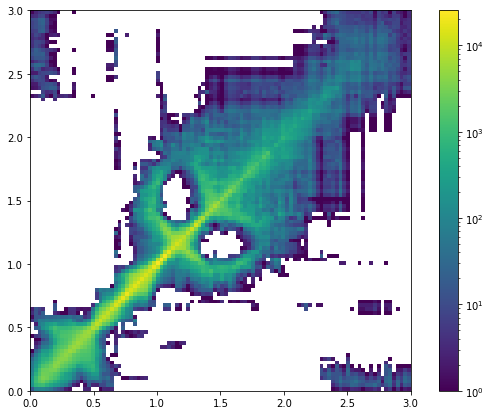

In [258]:

plt.figure(figsize=(10,7))
plt.imshow(density, origin='lower', extent=(bins[0], bins[-1], bins[0], bins[-1]), norm=LogNorm(vmin=1, vmax=25500))
plt.colorbar();